<img src = './logo.png'>

* ref: https://dacon.io/competitions/official/235680/overview/description

# Competetion Description

##. 평가
KOSPI-200과 KOSDAQ-150의 주어진 기간 중 마지막으로 거래된 가격(종가) 예측

평가 산식: NMAE * 100

평가 (Public, Private score)
public score: 11월 1일 ~ 11월 5일 주식 종료 예측값
private score: 11월 29일 ~ 12월 3일 주식 종료 예측값


## Feature
1.stock_list.csv : 종목 번호 데이터

종목명 : 주식 종목 명
종목코드 : 주식 종목 코드번호
상장시장 : 주식 종목 상장 시장 (KOSPI or KOSDAQ)
 

2.sample_submission.csv

sample_submission 데이터

sample_submission.shape : (10, 371)

# 0. Pre-Setting

## 0.1 Import

In [ ]:
# 
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

# warning
import warnings
warnings.filterwarnings(action='ignore')

# re
import re

# os
import os
import shutil # shutil.rmtree

# datetime
import datetime as dt 
from dateutil.rrule import rrule, YEARLY, MONTHLY, WEEKLY

# visualization
import matplotlib.pyplot as plt
plt.rc('font', family='Gothic') # For Windows. PLOT에서 한글 처리 -> 플롯 만드는 창에 넣어야 됨.

plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # - 기호 안 깨지게
plt.rcParams['font.size'] = 15

from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

%matplotlib inline 

# plt.figure(figsize=(12,4)) # plot 12:4 비율

import seaborn as sns
sns.set() # seaborn에서 회색 grid 깔아줌
sns.set(rc={'figure.figsize':(18, 5)}) # 결과 plot 크기 키워줌


In [ ]:
# 사이킷런
from sklearn.model_selection import train_test_split

# 사이킷런 분류
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import LinearSVC

# 사이킷런 분류 점수
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# 						 # ---> y_true, y_pred
# from sklearn.metrics import precision_recall_curve # y_true, probas_pred
# from sklearn.metrics import roc_auc_score, roc_curve # y_true, y_score

# 분류 ensemble
# import xgboost as xgb
# from xgboost import plot_importance 
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier # lgb.쓰기 귀찮으니까 Classifier까지 import
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [ ]:
# sklearn regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV

from sklearn.svm import SVC #linear SVC는 classifier 성 / SVC는 분류말고 회귀에도 쓸 수 있다.

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# sklearn metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score # squared=False로 하면 RMSE

In [ ]:
# sklearn scaler
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# sklearn augmentation
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV

In [ ]:
# ------------- tensorflow & keras -----------------
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation                 #-------------FC
from keras.layers import Conv2D, MaxPooling2D,Flatten      #-------------CNN
from keras.layers import LSTM                              #-------------RNN
from keras.preprocessing.image import ImageDataGenerator   #-------------Augmentation
from keras.preprocessing.image import array_to_img, img_to_array, load_img # ㄴ flow



from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint  #------------ callback

# --------------------- etc. -----------------------
from PIL import Image

# ----------------- fixing seed --------------------
np.random.seed(1024)
tf.random.set_seed(1024)

In [ ]:
! pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

In [ ]:
# colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## 0.2 Classes, Methods

In [ ]:
MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"

def target_split(df, shift_size = 1, target = 'Close'):
    X = df.drop(target, axis=1)
    y = df[target]
    y = y.shift(shift_size)
    return X.iloc[shift_size:,:], y.iloc[shift_size:]

def test_split(X, y, window_size = 20):

    test1_from = y.index[(np.where(y.index=='2021-11-01')[0][0] - window_size)]
    test2_from = y.index[(np.where(y.index=='2021-11-26')[0][0] - window_size)]

    X_train = X.loc[:'2021-10-29', :]
    y_train = y[:'2021-10-29']

    X_test1 = X.loc[test1_from:'2021-11-05', :] # 2021-11-02 ~ 2021-11-05 (전 날 기준, y축이 하루 밀려있기 때문)
    y_test1 = y[test1_from:'2021-11-05']

    X_test2 = X.loc[test2_from:'2021-12-02', :] # 2021-11-29 ~ 2021-12-03 (전 날 기준, y축이 하루 밀려있기 때문)
    y_test2 = y[test2_from:'2021-12-02']

    return X_train, y_train, X_test1, y_test1, X_test2, y_test2

def val_split(X_train, y_train, split_ratio=0.2):
    if X_train.shape[0]!=y_train.shape[0]:
        print('*********error!!!*********')

    else:
        val_size = int(X_train.shape[0]*split_ratio)
        
        X_val = X_train[-val_size:]
        X_train = X_train[:-val_size]

        y_val = y_train[-val_size:]
        y_train = y_train[:-val_size]

        # print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

        return X_train, X_val, y_train, y_val

class my_train():
    def __init__(self, X, y):
        self.X = X
        self.y = y

        self.X_window = None
        self.y_window = None

        self.model = None
        self.res = None # res.history = {'loss': , 'val_loss'}

    def window_data(self, window_size = 20):
        

        X_list = []
        y_list = []

        for i in range(len(self.X) - window_size):
            X_list.append(self.X.iloc[i : i+window_size, :])
            y_list.append(self.y.iloc[i+window_size])
            
        self.X_window = np.array(X_list)
        self.y_window = np.array(y_list)

        # print(self.X_window.shape, self.y_window.shape)
        return self.X_window, self.y_window


    def my_fit(self, hidden_layer=None, return_sequences = False, units__=16, epochs__ = 100, model_path = MODELPAHT__, model_save = False):
        # model layer
        if hidden_layer == None:
            hidden_layer = []
        else:
            hidden_layer = hidden_layer
        
        input_layer = LSTM(units = units__,
                            input_shape = (self.X_window.shape[1:]),
                            activation = 'tanh',
                            recurrent_activation = 'sigmoid',
                            dropout=0.0,
                            recurrent_dropout = 0.0,
                            return_sequences = return_sequences) # True(many to many), False(many to one)
        
        output_layer = Dense(units = 1)

        hidden_layer.insert(0, input_layer) 
        hidden_layer.append(output_layer)

        
        self.model = Sequential(hidden_layer)
        print(self.model.summary())

        # compile
        self.model.compile(loss="mae", optimizer='adam')# , metrics="mae")

        # callback
        callback_list = []
        if model_save == True:
            if os.path.exists(model_path):
                shutil.rmtree(model_path) 

            if not os.path.exists(model_path):
                os.mkdir(model_path)  

            check_point = ModelCheckpoint(filepath=model_path+'/mymodel_{epoch:02d}_{val_loss:.4f}.h5',
                    monitor='val_loss',
                    save_best_only=True,
                    save_weights_only=False
                       )
            callback_list.append(check_point)

        stop = EarlyStopping(patience=10, monitor='val_loss')
        callback_list.append(stop)

        # fit
        self.res = self.model.fit(self.X_window, self.y_window, 
                            callbacks=callback_list,
                            epochs = epochs__,
                            batch_size = 32,
                            validation_split=0.2
                            )
        
        # plot
        plt.plot(np.arange(len(self.res.history['loss'])), self.res.history['loss'], c='red', label='train_loss')
        plt.plot(np.arange(len(self.res.history['val_loss'])), self.res.history['val_loss'], c='blue', label='val_loss')
        plt.legend()
        plt.show()


    def my_predict(self, X_test, y_test = None, y_scaler = None, plot = False, window_size=20):

        # window data
        X_list = []
        y_list = []
        window_size = window_size

        for i in range(len(X_test) - window_size):
            X_list.append(X_test.iloc[i : i+window_size, :])
            if str(y_test) != 'None':
                y_list.append(y_test.iloc[i+window_size])
            
        X_test_window = np.array(X_list)
        y_test_window = np.array(y_list)
        print(X_test_window.shape, y_test_window.shape)
        # predict
        pred = self.model.predict(X_test_window)
        # print('predict.shape: ',pred.shape)
        
        if y_scaler != None:
            pred = y_scaler.inverse_transform(pred)

            if str(y_test) != 'None':
                y_test = y_scaler.inverse_transform(y_test_window)

        # score
        print('**'*30)
        print("NMAE: ", np.sum(abs(pred-y_test))*pred.shape[0]/np.mean(y_test))
        print('**'*30)

        # plot
        if plot == True:
            plt.plot(self.X.index[-X_test_window.shape[0]:], pred, c='red', label='pred')
            
            if str(y_test) != 'None':
                plt.plot(self.X.index[-X_test_window.shape[0]:], y_test, c='blue', label='ytest')
            
            plt.legend()
            plt.show()

        return pred



In [ ]:
# def target_split(df, shift_size = 1, target = 'Close'):
#     X = df.drop(target, axis=1)
#     y = df[target]
#     y = y.shift(shift_size)
#     return X.iloc[shift_size:,:], y.iloc[shift_size:]

In [ ]:
# def window_data(X, y, window_size = 20):
#     X = X.fillna(method = 'bfill')

#     X_list = []
#     y_list = []

#     for i in range(len(X) - window_size):
#         X_train=X.iloc[i : i+window_size, :]
#         y_train=y.iloc[i+window_size]
#         X_list.append(X_train)
#         y_list.append(y_train)

#     return np.array(X_list), np.array(y_list)

In [ ]:
# def val_split(X_train, y_train, split_ratio=0.2):
#     if X_train.shape[0]!=y_train.shape[0]:
#         print('*********error!!!*********')

#     else:
#         val_size = int(X_train.shape[0]*split_ratio)
        
#         X_val = X_train[-val_size:]
#         X_train = X_train[:-val_size]

#         y_val = y_train[-val_size:]
#         y_train = y_train[:-val_size]

#         print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

#         return X_train, X_val, y_train, y_val


# 1. Data Load

## 1.1 load

In [ ]:
# colab
# load train & submission data
stock_list = pd.read_csv('/content/gdrive/MyDrive/stock_price_d/dataset/stock_list.csv')
sub = pd.read_csv('/content/gdrive/MyDrive/stock_price_d/dataset/sample_submission (1).csv')

In [ ]:
com_df = pd.read_csv('/content/gdrive/MyDrive/stock_price_d/dataset/com_df.csv')

## 1.2 shape

In [ ]:
stock_list.shape, sub.shape

((370, 3), (10, 371))

## 1.3 info

In [ ]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   종목명     370 non-null    object
 1   종목코드    370 non-null    int64 
 2   상장시장    370 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.8+ KB


In [ ]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 371 entries, Day to 950130
dtypes: int64(370), object(1)
memory usage: 29.1+ KB


## 1.4 head

In [ ]:
stock_list.head(3)

,종목명,종목코드,상장시장
0,삼성전자,5930,KOSPI
1,SK하이닉스,660,KOSPI
2,NAVER,35420,KOSPI


In [ ]:
sub.head(3)

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.5 pre-processing

### 1.5.1 merge stock_list DataFrame & listed company info DataFrame

In [ ]:
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
com_df['stock_code']=com_df['stock_code'].apply(lambda x :  str(x).zfill(6))
com_df['stock_code_ori']=com_df['stock_code_ori'].apply(lambda x :  str(x).zfill(6))

In [ ]:
condition = com_df[(com_df.duplicated(subset='stock_code_ori', keep='first')) & (com_df['stock_code']==com_df['stock_code_ori'])]
com_df=com_df.drop(condition.index, axis=0)

In [ ]:
stock_list = pd.merge(stock_list, com_df, left_on='종목코드', right_on='stock_code', how='left')

In [ ]:
stock_list=stock_list.drop(['cd', 'nm', 'corp_name', 'stock_code', '표준코드', '단축코드', '한글 종목명', '한글 종목약명', '영문 종목명', 'yh_code', 'stock_code_ori'], axis=1)

In [ ]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 369
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   종목명           370 non-null    object 
 1   종목코드          370 non-null    object 
 2   상장시장          370 non-null    object 
 3   industry      357 non-null    object 
 4   main_product  356 non-null    object 
 5   listed_date   357 non-null    object 
 6   settle_month  357 non-null    object 
 7   hpage         348 non-null    object 
 8   상장일           357 non-null    object 
 9   증권구분          357 non-null    object 
 10  주식종류          357 non-null    object 
 11  액면가           357 non-null    object 
 12  상장주식수         357 non-null    float64
dtypes: float64(1), object(12)
memory usage: 40.5+ KB


In [ ]:
del(com_df)

In [ ]:
stock_list[stock_list['industry'].isna()]

,종목명,종목코드,상장시장,industry,main_product,listed_date,settle_month,hpage,상장일,증권구분,주식종류,액면가,상장주식수
68,KODEX 200,069500,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,KODEX 단기채권,153130,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,KODEX 200선물인버스2X,252670,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,TIGER 200,102110,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,KODEX 삼성그룹,102780,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,롯데리츠,330590,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,KODEX 단기채권PLUS,214980,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,KODEX 레버리지,122630,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,KODEX 종합채권(AA-이상)액티브,273130,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,KODEX 200TR,278530,KOSPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sdfasdfsadfasfsaf

NameError: ignored

## 1.6 load other data

### 1.6.1 VIX 

In [ ]:
# vix = fdr.DataReader('VIX', '2000-01-06', '2021-03-09') # S&P 500 VIX

In [ ]:
# vix.info()

In [ ]:
# plt.plot(vix['Close'], label='Close')
# plt.plot(vix['Change']*100, label='Change*100')
# plt.legend()
# plt.show()

### 1.6.2 Stock price

# 2. Predicting Sample stock price

## 2.1 Picking Sample

In [ ]:
sample_p = '006400'
sample_q = '035760'

In [ ]:
stock_list[(stock_list['종목코드']==sample_p) | (stock_list['종목코드']==sample_q)]

In [ ]:
start_date = '19900101'
end_date = '20211215'

name_list = ['p', 'q']
i=0

for code in (sample_p, sample_q): 
    globals()[f'stock_{name_list[i]}'] = fdr.DataReader(code, start = start_date, end = end_date)
    i+=1

In [ ]:
stock_q.info()

In [ ]:
stock_p.info()

In [ ]:
stock_p.plot()

In [ ]:
stock_q.plot()

## 2.2 Pre-processing & engineering

In [ ]:
X_p, y_p = target_split(stock_p, shift_size = 1)
X_q, y_q = target_split(stock_q, shift_size = 1)

In [ ]:
X_p.info(), X_q.info()

In [ ]:
y_p.isna().sum(), y_q.isna().sum()

In [ ]:
temp_list = ['p', 'q']

for idx in temp_list:
    globals()[f'mme_{idx}1'] = MinMaxScaler() # ex. mme_p1 = MinMaxScaler()
    globals()[f'mme_{idx}2'] = MinMaxScaler() # ex. mme_p2 = MinMaxScaler()

    temp = globals()[f'X_{idx}']
    globals()[f'X_{idx}2'] = globals()[f'mme_{idx}1'].fit_transform(temp) # ex. X_p = mme_p1(X_p)

    temp = globals()[f'y_{idx}'].values.reshape(-1,1)
    globals()[f'y_{idx}2'] = globals()[f'mme_{idx}2'].fit_transform(temp) # ex. y_p = mme_p2(y_p.values.reshape(-1,1))

In [ ]:
X_p = pd.DataFrame(X_p2, columns = X_p.columns, index = X_p.index)
y_p = pd.DataFrame(y_p2, columns = [y_p.name], index = y_p.index)
X_q = pd.DataFrame(X_q2, columns = X_q.columns, index = X_q.index)
y_q = pd.DataFrame(y_q2, columns = [y_q.name], index = y_q.index)

# 3. First_trial

In [ ]:
X_p_train, y_p_train = window_data(X_p, y_p, window_size = 20)
print(X_p_train.shape, y_p_train.shape)


X_q_train, y_q_train = window_data(X_q, y_q, window_size = 20)
print(X_q_train.shape, y_q_train.shape)

In [ ]:
model.summary()

In [ ]:
X_p_train, X_p_val, y_p_train, y_p_val = val_split(X_p_train, y_p_train)

In [ ]:
# many_to_one

lstm= LSTM(units =16, # 내보내는 개수
               input_shape = (X_p_train.shape[1:]),
                activation = 'tanh',
                recurrent_activation = 'sigmoid',
                dropout=0.0,
                recurrent_dropout = 0.0,
                return_sequences=False) # sequence내뱉는 걸 다음 놈한테 줄 거냐 말 거냐. True(many to many)는 뒷레이어한테도 준다. False면 옆 놈한테만 준다.(many to one)

model = Sequential()

model.add(lstm)
model.add(Dense(1, ))

In [ ]:
model.summary()

In [ ]:
model.compile(loss="mae", optimizer='adam')# , metrics="mae")

stop = EarlyStopping(patience=10, monitor='val_loss')

check_point = ModelCheckpoint(filepath='/content/gdrive/MyDrive/stock_price_d/models/mymodel_{epoch:02d}_{val_loss:.4f}.h5',
                    monitor='val_loss',          #------------어떤 점수를 기준으로 모니터링할까
                    save_best_only=True,         #------------이전보다 좋아질때만 저장
                    save_weights_only=False      #------------모델+가중치 같이 저장
                   ) 
res = model.fit(X_p_train, y_p_train, 
          callbacks=[stop, check_point],
          epochs = 100,
          batch_size = 32,
          validation_split=0.2
         )

In [ ]:
plt.plot(np.arange(len(res.history['val_loss'])), res.history['loss'], c='red', label='train_loss_9')
plt.plot(np.arange(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss_1')
plt.legend()
plt.show()


In [ ]:
pred = model.predict(X_p_val)
print(pred.shape, y_p_val.shape)

In [ ]:
plt.plot(X_p.index[-X_p_val.shape[0]:], pred, c='red', label='pred')
plt.plot(X_p.index[-X_p_val.shape[0]:], y_p_val, c='blue', label='ytest')
plt.legend()
plt.show()

In [ ]:
pred_orig   = mme_p2.inverse_transform(pred)
y_p_val_orig   = mme_p2.inverse_transform(y_p_val)
print(pred_orig[:5])

In [ ]:
np.sum(abs(pred_orig-y_p_val_orig))*pred_orig.shape[0]/np.sum(y_p_val_orig)

In [ ]:
plt.plot(X_p.index[-X_p_val.shape[0]:], pred_orig, c='red', label='pred')
plt.plot(X_p.index[-X_p_val.shape[0]:], y_p_val_orig, c='blue', label='real')
plt.legend()
plt.show()


# 4. train model with my_train

## 4.1 Sample

In [ ]:
# start_date = '19900101'
# end_date = '20211215'

# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
# WINDOW_SIZE__ = 20
# UNITS__= 16
# EPOCHS__ = 100
# STOCK_CODE = '035760'

# stock_q = fdr.DataReader(code, start = start_date, end = end_date)

# X, y = target_split(stock_q)

# mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
# mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

# X_scaled = mms_X.fit_transform(X)
# y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

# X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
# y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

# X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
# X_train, X_val, y_train, y_val = val_split(X_train, y_train)


# mt = my_train(X_train, y_train)

# mt.window_data()

# mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

# pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
# pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

# pred = np.zeros((10,1))
# pred[:5] = pred1
# pred[5:] = pred2

# sub[STOCK_CODE] = pred


## 4.2 loop

In [ ]:
stock_list = sub.columns
len(stock_list)

In [ ]:
sub.columns

In [ ]:
# # 한 기업 당 1분 30초 가량 걸리는 관계로 start_date 조정 위해 중단.
# # 1~17번째 기업까지는 기록 저장된 상태로 둠.

# i = 0
# # len(stock_list)

# for stock_code in stock_list[1:]:
#     i += 1
#     print('**'*30)
#     print(370-i,"remain......") # 370 == len(stock_list)-1
#     print('**'*30)

#     start_date = '19900101'
#     end_date = '20211215'

#     MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
#     WINDOW_SIZE__ = 20
#     UNITS__= 16
#     EPOCHS__ = 100
#     STOCK_CODE = stock_code

#     stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)

#     X, y = target_split(stock_q)

#     mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
#     mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

#     X_scaled = mms_X.fit_transform(X)
#     y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

#     X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
#     y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

#     X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
#     X_train, X_val, y_train, y_val = val_split(X_train, y_train)


#     mt = my_train(X_train, y_train)

#     mt.window_data()

#     mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

#     pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
#     pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

#     pred = np.zeros((10,1))
#     pred[:5] = pred1
#     pred[5:] = pred2

#     sub[STOCK_CODE] = pred


In [ ]:
# # 속도 개선 위해 44번째에서 중단 후 코드 수정

# i = 18
# # len(stock_list)

# for stock_code in stock_list[18:]:
#     i += 1
#     print('**'*30)
#     print(370-i,"remain......") # 370 == len(stock_list)-1
#     print('**'*30)

#     start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
#     end_date = '20211215'

#     MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
#     WINDOW_SIZE__ = 20
#     UNITS__= 16
#     EPOCHS__ = 100
#     STOCK_CODE = stock_code

#     stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)

#     X, y = target_split(stock_q)

#     mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
#     mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

#     X_scaled = mms_X.fit_transform(X)
#     y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

#     X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
#     y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

#     X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
#     X_train, X_val, y_train, y_val = val_split(X_train, y_train)


#     mt = my_train(X_train, y_train)

#     mt.window_data()

#     mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

#     pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
#     pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

#     pred = np.zeros((10,1))
#     pred[:5] = pred1
#     pred[5:] = pred2

#     sub[STOCK_CODE] = pred


In [ ]:
# 런타임 에러로 종료됨.

i = 44
# len(stock_list)

start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
end_date = '20211215'
# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
WINDOW_SIZE__ = 20
UNITS__= 16
EPOCHS__ = 100
STOCK_CODE = stock_code

for stock_code in stock_list[44:]:
    i += 1
    print('**'*30)
    print(370-i,"remain......") # 370 == len(stock_list)-1
    print('**'*30)
   

    stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)

    X, y = target_split(stock_q)

    mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
    mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

    X_scaled = mms_X.fit_transform(X)
    y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

    X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
    y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

    X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
    X_train, X_val, y_train, y_val = val_split(X_train, y_train)


    mt = my_train(X_train, y_train)

    mt.window_data()

    mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

    pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
    pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

    pred = np.zeros((10,1))
    pred[:5] = pred1
    pred[5:] = pred2

    sub[STOCK_CODE] = pred


# 5. Feature Engineering

* 많은 데이터에서 하락기에 있는 데이터는 과대예측, 상승기에 있는 과소예측하는 경향 존재.(거의 유사한 경우도 많다.)
-> 과거보다 커진 변동성을 반영하고 있지 못하다.
-> 단기 이동평균선 도입 필요

## 5.1 Moving Average

### 네이버 주식에서 MovingAverage 변수 도입 시 성능 변화(5,20,50)

In [ ]:

start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
end_date = '20211215'
# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
WINDOW_SIZE__ = 20
UNITS__= 16
EPOCHS__ = 100
STOCK_CODE = '035420'


X, y = target_split(stock_q)

mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

X_scaled = mms_X.fit_transform(X)
y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)



X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
X_train, X_val, y_train, y_val = val_split(X_train, y_train)


mt = my_train(X_train, y_train)

mt.window_data()

mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

pred = np.zeros((10,1))
pred[:5] = pred1
pred[5:] = pred2

# sub[STOCK_CODE] = pred


In [ ]:

start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
end_date = '20211215'
# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
WINDOW_SIZE__ = 20
UNITS__= 16
EPOCHS__ = 100
STOCK_CODE = '035420'


# -----------------------------moving average ---------------------------
stock_q = fdr.DataReader(STOCK_CODE, start = start_date, end = end_date)
stock_q = stock_q.fillna(method = 'bfill')
stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
# stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
# stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
stock_q = stock_q.dropna()
# -----------------------------------------------------------------------

X, y = target_split(stock_q)

mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

X_scaled = mms_X.fit_transform(X)
y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)



X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
X_train, X_val, y_train, y_val = val_split(X_train, y_train)


mt = my_train(X_train, y_train)

mt.window_data()

mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

pred = np.zeros((10,1))
pred[:5] = pred1
pred[5:] = pred2

# sub[STOCK_CODE] = pred


In [ ]:

start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
end_date = '20211215'
# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
WINDOW_SIZE__ = 20
UNITS__= 16
EPOCHS__ = 100
STOCK_CODE = '035420'


# -----------------------------moving average ---------------------------
stock_q = fdr.DataReader(STOCK_CODE, start = start_date, end = end_date)
stock_q = stock_q.fillna(method = 'bfill')
stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
# stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
stock_q = stock_q.dropna()
# -----------------------------------------------------------------------

X, y = target_split(stock_q)

mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

X_scaled = mms_X.fit_transform(X)
y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)



X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
X_train, X_val, y_train, y_val = val_split(X_train, y_train)


mt = my_train(X_train, y_train)

mt.window_data()

mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

pred = np.zeros((10,1))
pred[:5] = pred1
pred[5:] = pred2

# sub[STOCK_CODE] = pred


In [ ]:

start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
end_date = '20211215'
# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
WINDOW_SIZE__ = 20
UNITS__= 16
EPOCHS__ = 100
STOCK_CODE = '035420'


# -----------------------------moving average ---------------------------
stock_q = fdr.DataReader(STOCK_CODE, start = start_date, end = end_date)
stock_q = stock_q.fillna(method = 'bfill')
stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
stock_q = stock_q.dropna()
# -----------------------------------------------------------------------

X, y = target_split(stock_q)

mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

X_scaled = mms_X.fit_transform(X)
y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)



X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
X_train, X_val, y_train, y_val = val_split(X_train, y_train)


mt = my_train(X_train, y_train)

mt.window_data()

mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

pred = np.zeros((10,1))
pred[:5] = pred1
pred[5:] = pred2

# sub[STOCK_CODE] = pred


### 결론: ma 5와 ma 20을 도입했을 때 가장 성능이 좋음.(하나의 기업을 가지고만 판별했기 때문에 검증 필요)

In [ ]:
i = 0
# len(stock_list)

start_date = '20170101' # 미중 무역전쟁 심화, 코로나 위기가 있는 기간보다 넓게 잡기 위해 2017로 선정
end_date = '20211215'
# MODELPAHT__ = "/content/gdrive/MyDrive/stock_price_d/models"
SUBPATH__ = "/content/gdrive/MyDrive/stock_price_d/sub"
WINDOW_SIZE__ = 20
UNITS__= 16
EPOCHS__ = 100

# STOCK_CODE = stock_code

stock_list = sub.columns
error_list = []

In [ ]:
######################## 런타임 에러로 그냥 43번째부터 진행
i=43
for stock_code in stock_list[43:51]:
    i += 1
    print('**'*30)
    print(370-i,"remain......") # 370 == len(stock_list)-1
    print('**'*30)
   

    stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)
    # -----------------------------moving average ---------------------------
    stock_q = stock_q.fillna(method = 'bfill')
    stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
    stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
    # stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
    stock_q = stock_q.dropna()
    # -----------------------------------------------------------------------

    X, y = target_split(stock_q)

    mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
    mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

    X_scaled = mms_X.fit_transform(X)
    y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

    X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
    y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

    X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
    X_train, X_val, y_train, y_val = val_split(X_train, y_train)


    mt = my_train(X_train, y_train)

    mt.window_data()

    mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

    pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
    pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

    pred = np.zeros((10,1))
    pred[:5] = pred1
    pred[5:] = pred2

    sub[stock_code] = pred
sub.to_csv(f'{SUBPATH__}/sub1.csv')

In [ ]:
# sub.to_csv(f'{SUBPATH__}/sub1.csv')

In [ ]:
i=51
for stock_code in stock_list[51:101]:
    i += 1
    print('**'*30)
    print(370-i,"remain......") # 370 == len(stock_list)-1
    print('**'*30)
   

    stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)
    # -----------------------------moving average ---------------------------
    stock_q = stock_q.fillna(method = 'bfill')
    stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
    stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
    # stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
    stock_q = stock_q.dropna()
    # -----------------------------------------------------------------------

    X, y = target_split(stock_q)

    mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
    mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

    X_scaled = mms_X.fit_transform(X)
    y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

    X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
    y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

    X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
    X_train, X_val, y_train, y_val = val_split(X_train, y_train)


    mt = my_train(X_train, y_train)

    mt.window_data()

    mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

    pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
    pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

    pred = np.zeros((10,1))
    pred[:5] = pred1
    pred[5:] = pred2

    sub[stock_code] = pred
sub.to_csv(f'{SUBPATH__}/sub2.csv')

In [ ]:
i=101
for stock_code in stock_list[101:151]:
    i += 1
    print('**'*30)
    print(370-i,"remain......") # 370 == len(stock_list)-1
    print('**'*30)
   
    try:
        stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)
        # -----------------------------moving average ---------------------------
        stock_q = stock_q.fillna(method = 'bfill')
        stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
        stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
        # stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
        stock_q = stock_q.dropna()
        # -----------------------------------------------------------------------

        X, y = target_split(stock_q)

        mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
        mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

        X_scaled = mms_X.fit_transform(X)
        y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

        X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
        y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

        X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
        X_train, X_val, y_train, y_val = val_split(X_train, y_train)


        mt = my_train(X_train, y_train)

        mt.window_data()

        mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

        pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
        pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

        pred = np.zeros((10,1))
        pred[:5] = pred1
        pred[5:] = pred2

        sub[stock_code] = pred
    except:
        error_list.append(stock_code)

sub.to_csv(f'{SUBPATH__}/sub3.csv')
print(error_list)

In [ ]:
i=151
for stock_code in stock_list[151:201]:
    i += 1
    print('**'*30)
    print(370-i,"remain......") # 370 == len(stock_list)-1
    print('**'*30)
   
    try:
        stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)
        # -----------------------------moving average ---------------------------
        stock_q = stock_q.fillna(method = 'bfill')
        stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
        stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
        # stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
        stock_q = stock_q.dropna()
        # -----------------------------------------------------------------------

        X, y = target_split(stock_q)

        mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
        mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

        X_scaled = mms_X.fit_transform(X)
        y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

        X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
        y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

        X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
        X_train, X_val, y_train, y_val = val_split(X_train, y_train)


        mt = my_train(X_train, y_train)

        mt.window_data()

        mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

        pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
        pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

        pred = np.zeros((10,1))
        pred[:5] = pred1
        pred[5:] = pred2

        sub[stock_code] = pred

    except:
        error_list.append(stock_code)
sub.to_csv(f'{SUBPATH__}/sub4.csv')
print(error_list)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
i=201
for stock_code in stock_list[201:251]:
    i += 1
    print('**'*30)
    print(370-i,"remain......") # 370 == len(stock_list)-1
    print('**'*30)
   
    try:
        stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)
        # -----------------------------moving average ---------------------------
        stock_q = stock_q.fillna(method = 'bfill')
        stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
        stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
        # stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
        stock_q = stock_q.dropna()
        # -----------------------------------------------------------------------

        X, y = target_split(stock_q)

        mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
        mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

        X_scaled = mms_X.fit_transform(X)
        y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

        X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
        y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

        X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
        X_train, X_val, y_train, y_val = val_split(X_train, y_train)


        mt = my_train(X_train, y_train)

        mt.window_data()

        mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

        pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
        pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

        pred = np.zeros((10,1))
        pred[:5] = pred1
        pred[5:] = pred2

        sub[stock_code] = pred
    
    except:
        error_list.append(stock_code)
sub.to_csv(f'{SUBPATH__}/sub5.csv')
print(error_list)

Output hidden; open in https://colab.research.google.com to view.

************************************************************
118 remain......
************************************************************
Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_112 (LSTM)             (None, 16)                1536      
                                                                 
 dense_112 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 4s 48ms/step - loss: 0.0227 - val_loss: 0.1269
Epoch 2/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0098 - val_loss: 0.0453
Epoch 3/100
23/23 [==============================] - 0s 12ms/step - loss: 0.0065 - val_loss: 0.0450
Ep

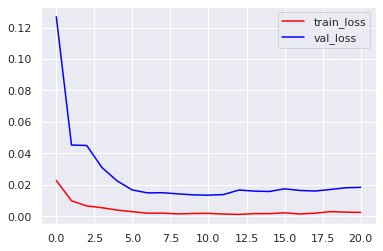

(5, 20, 7) (5, 1)
************************************************************
NMAE:  3.1597644158129423
************************************************************


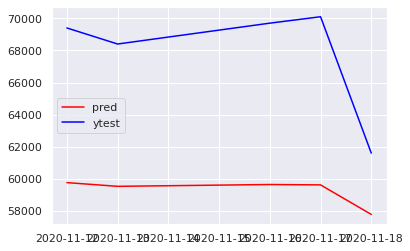

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.9790550307887058
************************************************************


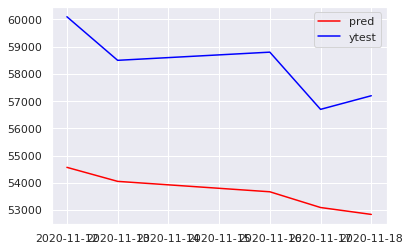

************************************************************
117 remain......
************************************************************
Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_113 (LSTM)             (None, 16)                1536      
                                                                 
 dense_113 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 2s 30ms/step - loss: 0.1618 - val_loss: 0.1407
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0550 - val_loss: 0.0846
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0269 - val_loss: 0.0165
Epo

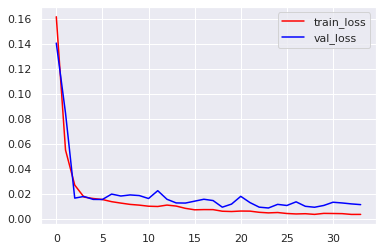

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.16929801096388453
************************************************************


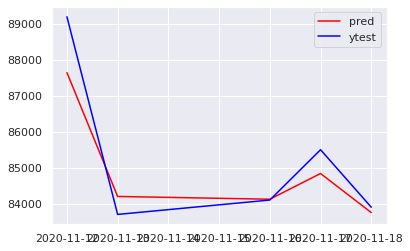

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.15633182010135135
************************************************************


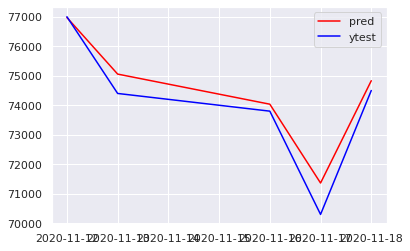

************************************************************
116 remain......
************************************************************
Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_114 (LSTM)             (None, 16)                1536      
                                                                 
 dense_114 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 33ms/step - loss: 0.0634 - val_loss: 0.0749
Epoch 2/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0503 - val_loss: 0.0529
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0421 - val_loss: 0.0273
Epoc

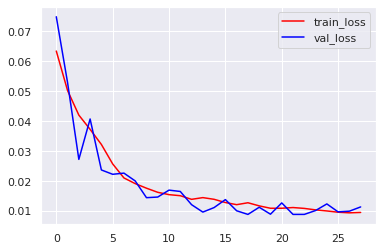

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.937092300134203
************************************************************


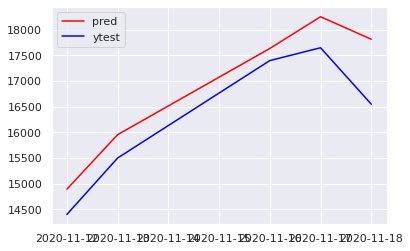

(5, 20, 7) (5, 1)
************************************************************
NMAE:  2.55006186694291
************************************************************


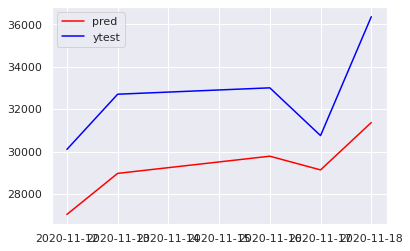

************************************************************
115 remain......
************************************************************
Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_115 (LSTM)             (None, 16)                1536      
                                                                 
 dense_115 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 2s 31ms/step - loss: 0.0337 - val_loss: 0.1143
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0148 - val_loss: 0.0798
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0582
Epo

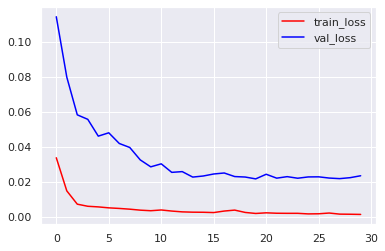

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.7086715384848528
************************************************************


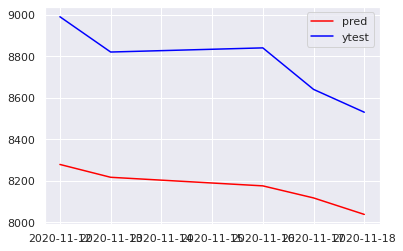

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.0351654707107414
************************************************************


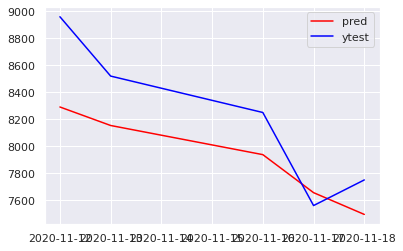

************************************************************
114 remain......
************************************************************
Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_116 (LSTM)             (None, 16)                1536      
                                                                 
 dense_116 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 2s 31ms/step - loss: 0.0385 - val_loss: 0.0225
Epoch 2/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0127 - val_loss: 0.0232
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0109 - val_loss: 0.0197
Epoc

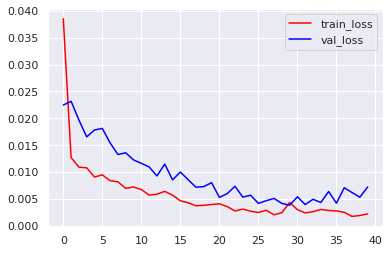

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.1077222781389933
************************************************************


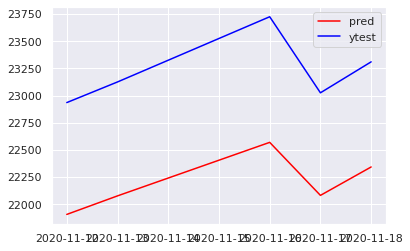

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.8291928558781869
************************************************************


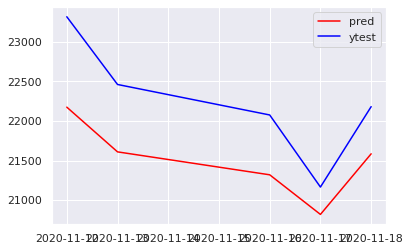

************************************************************
113 remain......
************************************************************
Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_117 (LSTM)             (None, 16)                1536      
                                                                 
 dense_117 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 2s 31ms/step - loss: 0.1499 - val_loss: 0.1434
Epoch 2/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0684 - val_loss: 0.0669
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0243 - val_loss: 0.0330
Ep

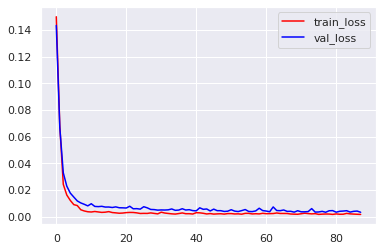

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.5557627107435101
************************************************************


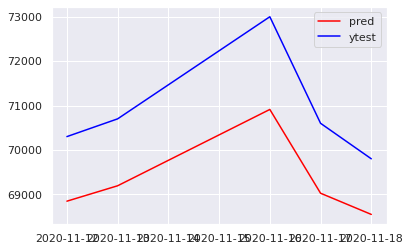

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.28954395214160905
************************************************************


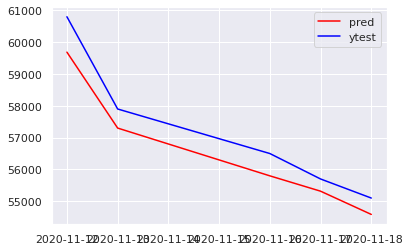

************************************************************
112 remain......
************************************************************
Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_118 (LSTM)             (None, 16)                1536      
                                                                 
 dense_118 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 2s 29ms/step - loss: 0.2600 - val_loss: 0.1389
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0667 - val_loss: 0.0519
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0423 - val_loss: 0.0287
Ep

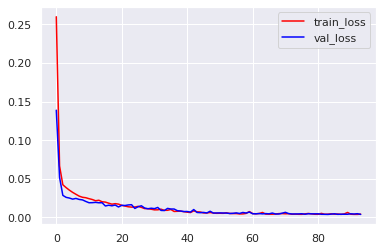

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.062095289785783346
************************************************************


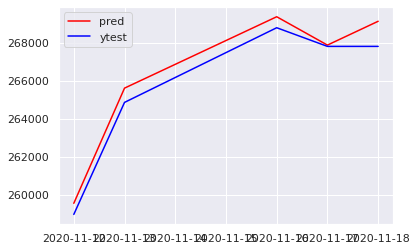

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.06772719043283533
************************************************************


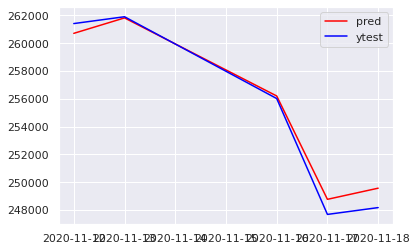

************************************************************
111 remain......
************************************************************
Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_119 (LSTM)             (None, 16)                1536      
                                                                 
 dense_119 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 30ms/step - loss: 0.0805 - val_loss: 0.2811
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0335 - val_loss: 0.1106
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0112 - val_loss: 0.0719
Epo

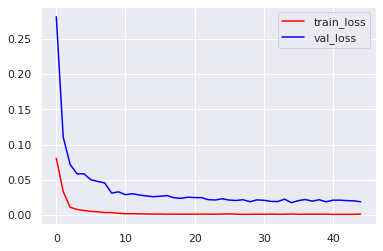

(5, 20, 7) (5, 1)
************************************************************
NMAE:  4.561478714542037
************************************************************


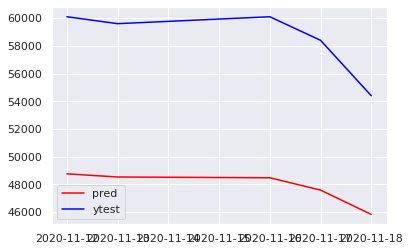

(5, 20, 7) (5, 1)
************************************************************
NMAE:  4.091516336475914
************************************************************


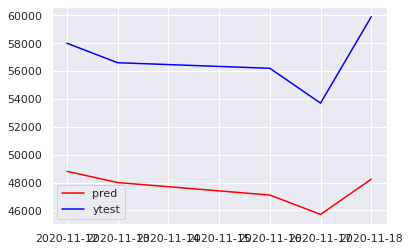

************************************************************
110 remain......
************************************************************
Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_120 (LSTM)             (None, 16)                1536      
                                                                 
 dense_120 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 43ms/step - loss: 0.0226 - val_loss: 0.1151
Epoch 2/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0079 - val_loss: 0.0851
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0620
Ep

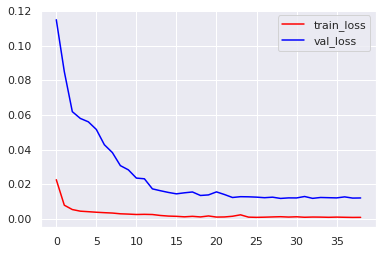

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.40549435436125514
************************************************************


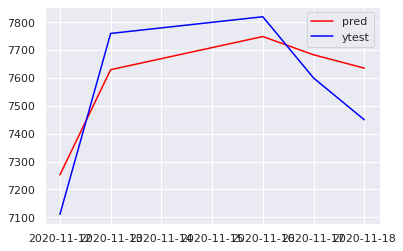

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.7486585025587942
************************************************************


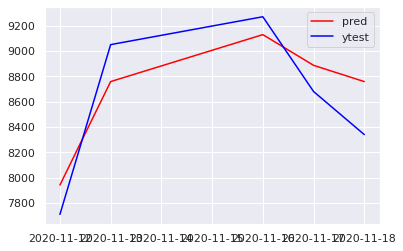

************************************************************
109 remain......
************************************************************
Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_121 (LSTM)             (None, 16)                1536      
                                                                 
 dense_121 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 2s 30ms/step - loss: 0.0612 - val_loss: 0.0393
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0205 - val_loss: 0.0492
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0169 - val_loss: 0.0306
Ep

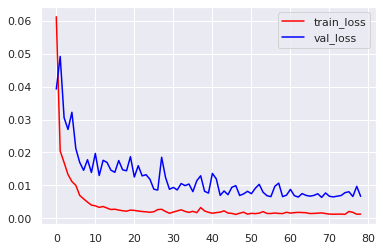

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.2608301739518287
************************************************************


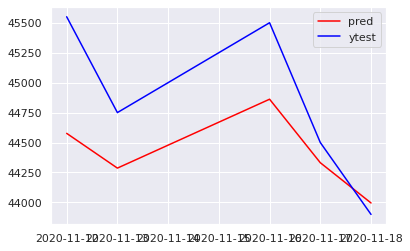

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.34562579932161924
************************************************************


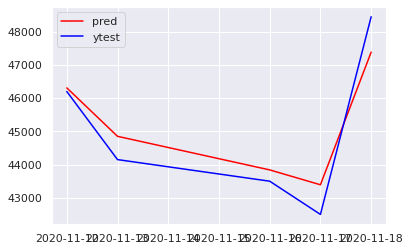

************************************************************
108 remain......
************************************************************
Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_122 (LSTM)             (None, 16)                1536      
                                                                 
 dense_122 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 2s 31ms/step - loss: 0.0172 - val_loss: 0.0552
Epoch 2/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0058 - val_loss: 0.0204
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0046 - val_loss: 0.0186
Epo

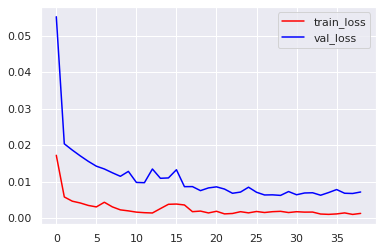

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.9928967748804001
************************************************************


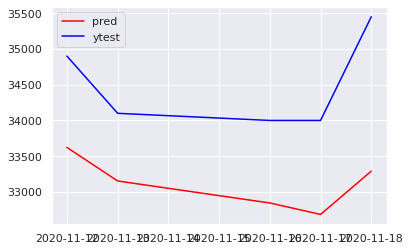

(5, 20, 7) (5, 1)
************************************************************
NMAE:  2.4427325330554375
************************************************************


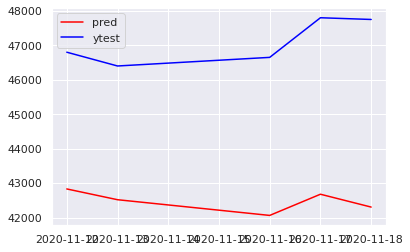

************************************************************
107 remain......
************************************************************
Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_123 (LSTM)             (None, 16)                1536      
                                                                 
 dense_123 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 42ms/step - loss: 0.1413 - val_loss: 0.1263
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0372 - val_loss: 0.0665
Epoch 3/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0229 - val_loss: 0.0467
Ep

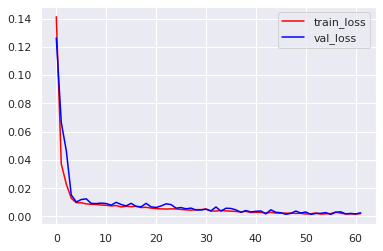

(5, 20, 7) (5, 1)
************************************************************
NMAE:  4.065813163433382
************************************************************


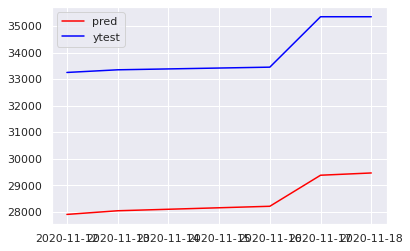

(5, 20, 7) (5, 1)
************************************************************
NMAE:  4.512311036409324
************************************************************


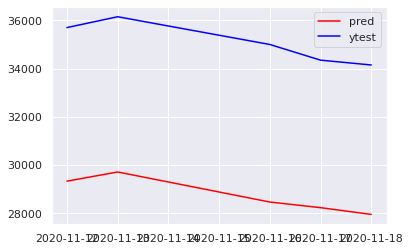

************************************************************
106 remain......
************************************************************
Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_124 (LSTM)             (None, 16)                1536      
                                                                 
 dense_124 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 31ms/step - loss: 0.3342 - val_loss: 0.0532
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0579 - val_loss: 0.0532
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0350 - val_loss: 0.0607
Ep

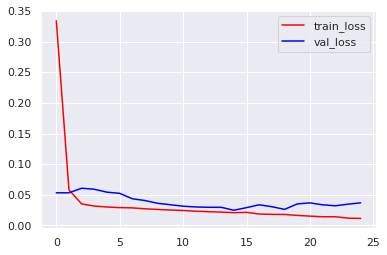

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.7026175858229262
************************************************************


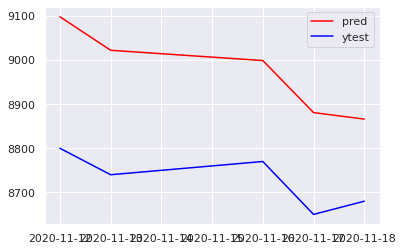

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.6994350741709637
************************************************************


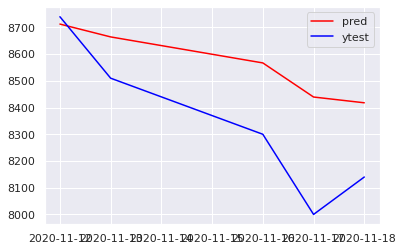

************************************************************
105 remain......
************************************************************
Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_125 (LSTM)             (None, 16)                1536      
                                                                 
 dense_125 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 31ms/step - loss: 0.0497 - val_loss: 0.0695
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0240 - val_loss: 0.0186
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0203 - val_loss: 0.0165
Ep

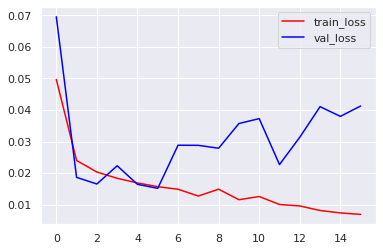

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.36091908861758987
************************************************************


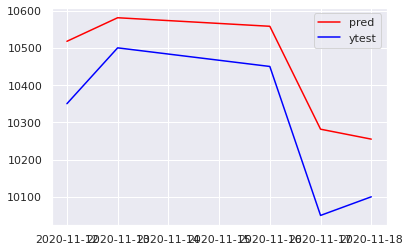

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.1548243033924712
************************************************************


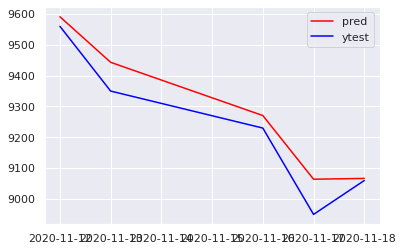

************************************************************
104 remain......
************************************************************
Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_126 (LSTM)             (None, 16)                1536      
                                                                 
 dense_126 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 43ms/step - loss: 0.2254 - val_loss: 0.2495
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0924 - val_loss: 0.0982
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0348 - val_loss: 0.0201
Ep

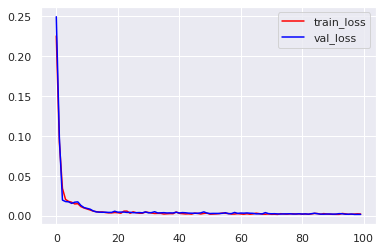

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.029926356445890007
************************************************************


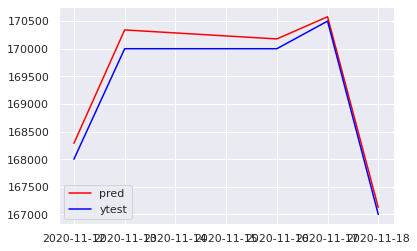

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.06323668204697987
************************************************************


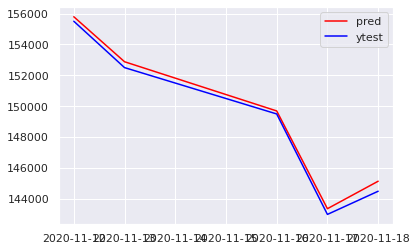

************************************************************
103 remain......
************************************************************
Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_127 (LSTM)             (None, 16)                1536      
                                                                 
 dense_127 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 2s 32ms/step - loss: 0.2550 - val_loss: 0.2987
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0693 - val_loss: 0.0694
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0311 - val_loss: 0.0790
Ep

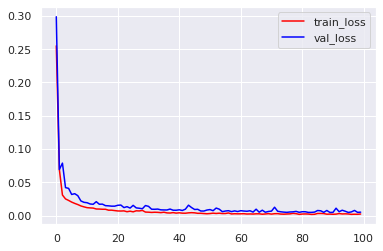

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.0577048823016565
************************************************************


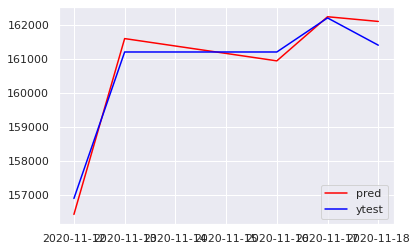

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.08986507963062099
************************************************************


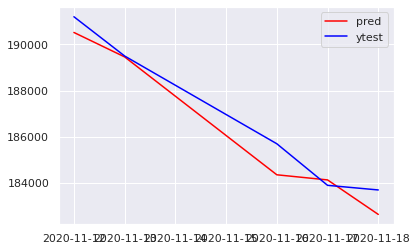

************************************************************
102 remain......
************************************************************
Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_128 (LSTM)             (None, 16)                1536      
                                                                 
 dense_128 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 32ms/step - loss: 0.0472 - val_loss: 0.0847
Epoch 2/100
23/23 [==============================] - 0s 12ms/step - loss: 0.0205 - val_loss: 0.0280
Epoch 3/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0054 - val_loss: 0.0128
Ep

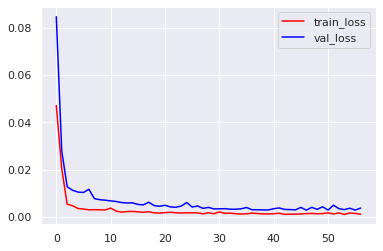

(5, 20, 7) (5, 1)
************************************************************
NMAE:  3.3724545787886306
************************************************************


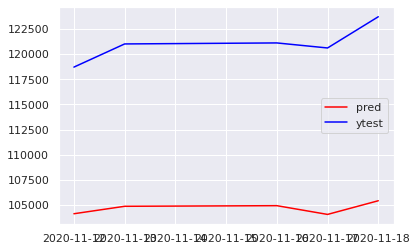

(5, 20, 7) (5, 1)
************************************************************
NMAE:  4.650899778819201
************************************************************


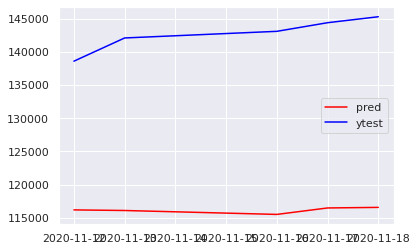

************************************************************
101 remain......
************************************************************
Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_129 (LSTM)             (None, 16)                1536      
                                                                 
 dense_129 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 43ms/step - loss: 0.0416 - val_loss: 0.1698
Epoch 2/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0188 - val_loss: 0.0759
Epoch 3/100
23/23 [==============================] - 0s 12ms/step - loss: 0.0166 - val_loss: 0.0956
Ep

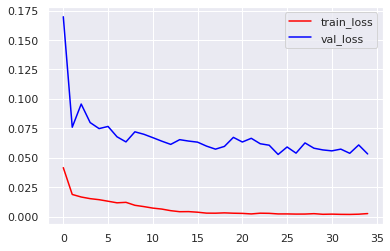

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.2895251699093817
************************************************************


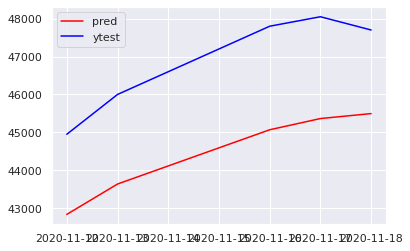

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.4593484565162271
************************************************************


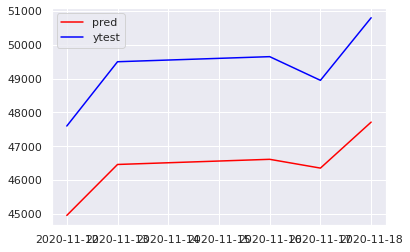

************************************************************
100 remain......
************************************************************
Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_130 (LSTM)             (None, 16)                1536      
                                                                 
 dense_130 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 32ms/step - loss: 0.0532 - val_loss: 0.0302
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0249 - val_loss: 0.0264
Epoch 3/100
23/23 [==============================] - 0s 12ms/step - loss: 0.0202 - val_loss: 0.0228
Ep

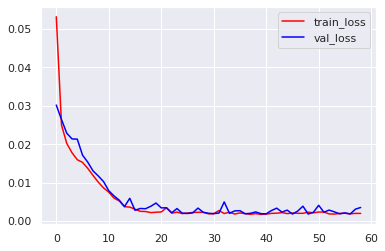

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.54082043869804
************************************************************


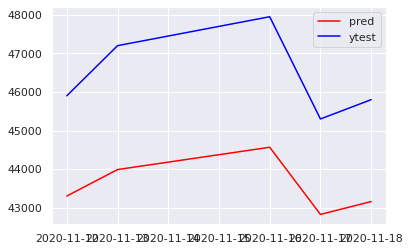

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.7122389225450403
************************************************************


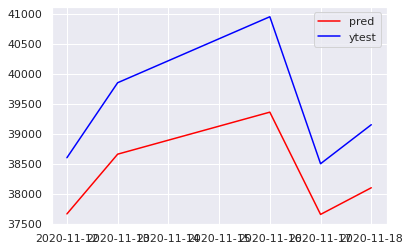

************************************************************
99 remain......
************************************************************
Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_131 (LSTM)             (None, 16)                1536      
                                                                 
 dense_131 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 32ms/step - loss: 0.0345 - val_loss: 0.0322
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0215 - val_loss: 0.0204
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0175 - val_loss: 0.0163
Epo

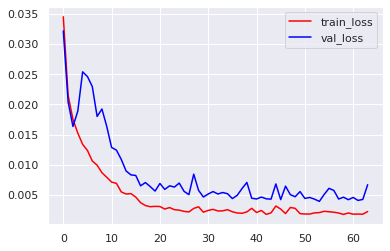

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.8665519080674952
************************************************************


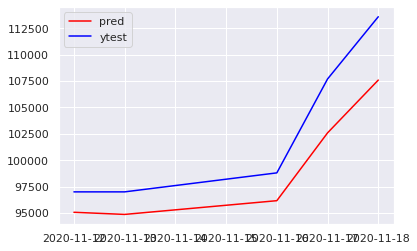

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.848410801130389
************************************************************


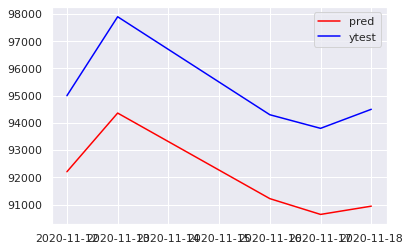

************************************************************
98 remain......
************************************************************
Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_132 (LSTM)             (None, 16)                1536      
                                                                 
 dense_132 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 42ms/step - loss: 0.1349 - val_loss: 0.0579
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0501 - val_loss: 0.0516
Epoch 3/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0427 - val_loss: 0.0475
Epo

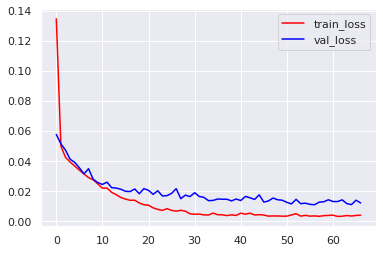

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.08307724845075017
************************************************************


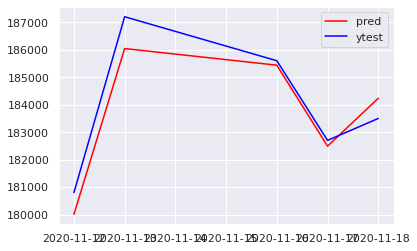

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.22335020164081973
************************************************************


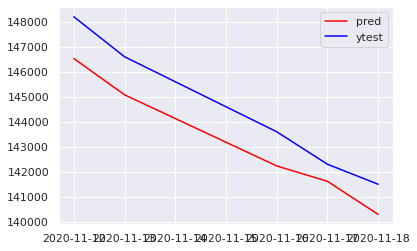

************************************************************
97 remain......
************************************************************
Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_133 (LSTM)             (None, 16)                1536      
                                                                 
 dense_133 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 32ms/step - loss: 0.0227 - val_loss: 0.0262
Epoch 2/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0090 - val_loss: 0.0150
Epoch 3/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0043 - val_loss: 0.0105
Epo

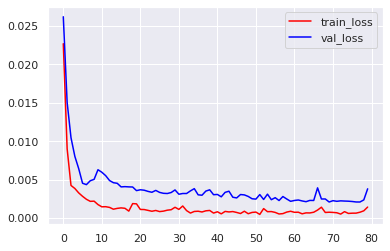

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.2519270467322563
************************************************************


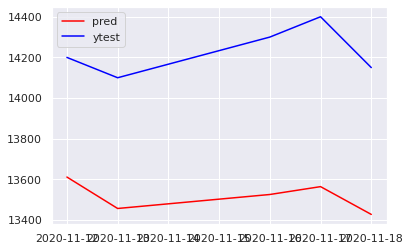

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.0025910787156358
************************************************************


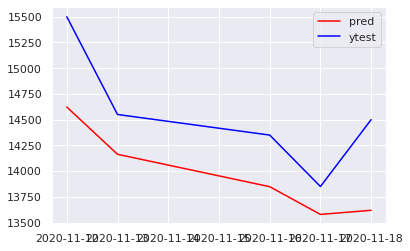

************************************************************
96 remain......
************************************************************
Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_134 (LSTM)             (None, 16)                1536      
                                                                 
 dense_134 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 32ms/step - loss: 0.2103 - val_loss: 0.1383
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0755 - val_loss: 0.0454
Epoch 3/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0419 - val_loss: 0.0192
Epo

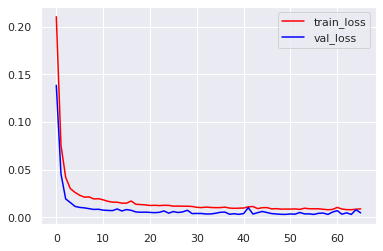

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.21594319690022895
************************************************************


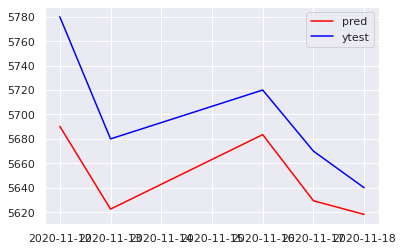

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.2572965983517206
************************************************************


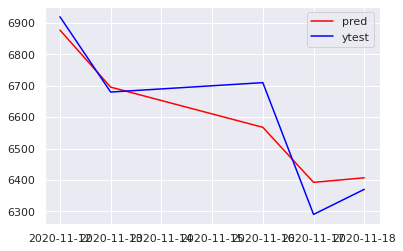

************************************************************
95 remain......
************************************************************
Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_135 (LSTM)             (None, 16)                1536      
                                                                 
 dense_135 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 32ms/step - loss: 0.2699 - val_loss: 0.0182
Epoch 2/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0411 - val_loss: 0.0465
Epoch 3/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0092 - val_loss: 0.0511
Epo

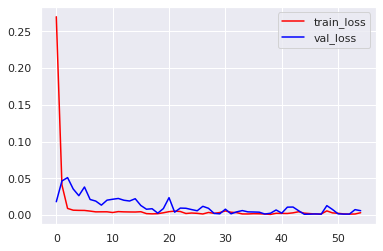

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.0188898857233071
************************************************************


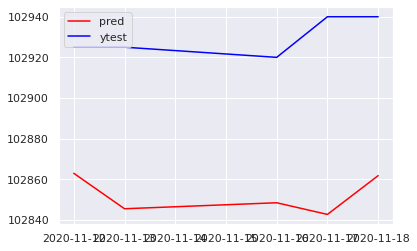

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.01892554458113322
************************************************************


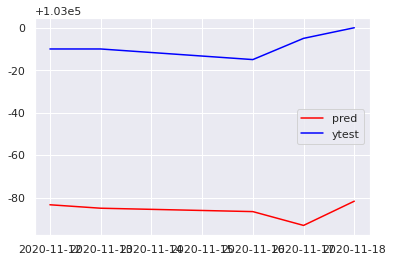

************************************************************
94 remain......
************************************************************
Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_136 (LSTM)             (None, 16)                1536      
                                                                 
 dense_136 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 34ms/step - loss: 0.1588 - val_loss: 0.0601
Epoch 2/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0299 - val_loss: 0.0246
Epoch 3/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0213 - val_loss: 0.0244
Epo

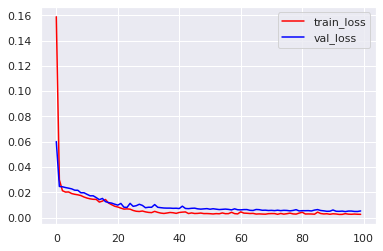

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.0393875604078265
************************************************************


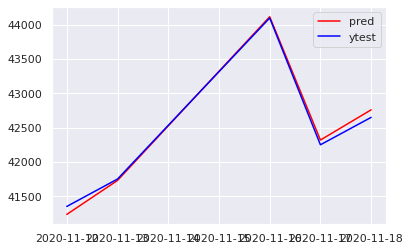

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.18848455482736573
************************************************************


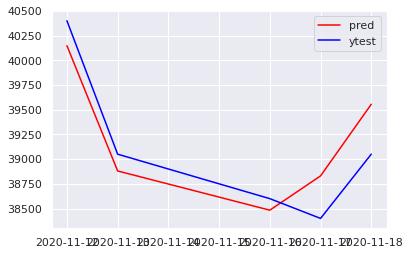

************************************************************
93 remain......
************************************************************
Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_137 (LSTM)             (None, 16)                1536      
                                                                 
 dense_137 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 33ms/step - loss: 0.1553 - val_loss: 0.1442
Epoch 2/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0679 - val_loss: 0.0620
Epoch 3/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0334 - val_loss: 0.0189
Epo

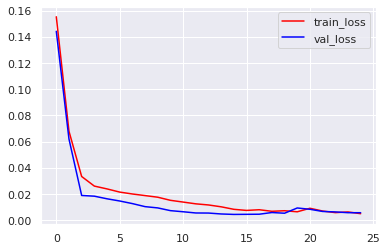

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.09418818995316681
************************************************************


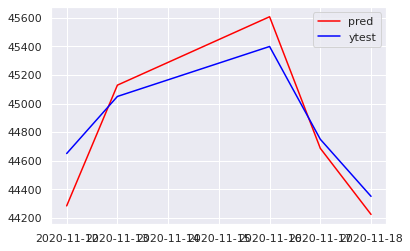

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.2485793153990671
************************************************************


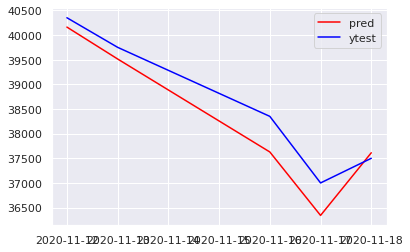

************************************************************
92 remain......
************************************************************
Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_138 (LSTM)             (None, 16)                1536      
                                                                 
 dense_138 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
22/22 [==============================] - 3s 33ms/step - loss: 0.0325 - val_loss: 0.0242
Epoch 2/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0168 - val_loss: 0.0190
Epoch 3/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0141 - val_loss: 0.0153
Epo

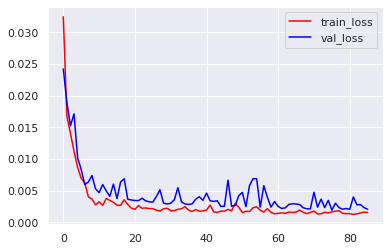

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.7901155531181836
************************************************************


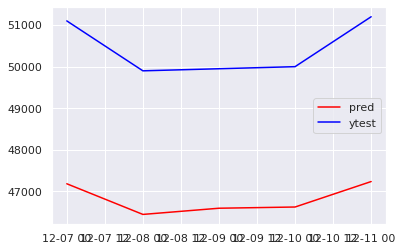

(5, 20, 7) (5, 1)
************************************************************
NMAE:  2.8268313633150366
************************************************************


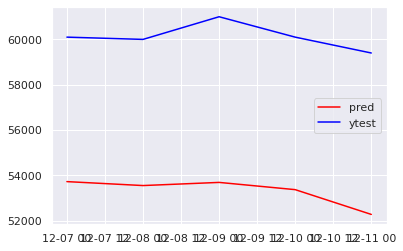

************************************************************
91 remain......
************************************************************
Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_139 (LSTM)             (None, 16)                1536      
                                                                 
 dense_139 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 32ms/step - loss: 0.1424 - val_loss: 0.1725
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0486 - val_loss: 0.1440
Epoch 3/100
23/23 [==============================] - 0s 12ms/step - loss: 0.0388 - val_loss: 0.1157
Epo

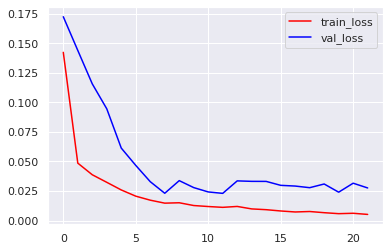

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.9843229241327408
************************************************************


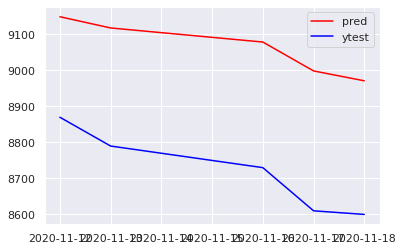

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.0985393928604066
************************************************************


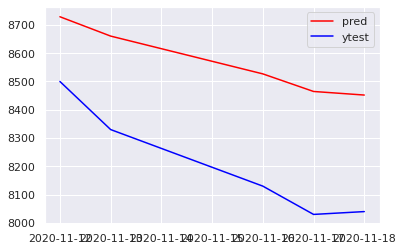

************************************************************
90 remain......
************************************************************
Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_140 (LSTM)             (None, 16)                1536      
                                                                 
 dense_140 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
22/22 [==============================] - 3s 35ms/step - loss: 0.1498 - val_loss: 0.2240
Epoch 2/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0473 - val_loss: 0.0524
Epoch 3/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0253 - val_loss: 0.0647
Epo

In [ ]:
i=251
for stock_code in stock_list[251:301]:
    i += 1
    print('**'*30)
    print(370-i,"remain......") # 370 == len(stock_list)-1
    print('**'*30)
   
    try:
        stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)
        # -----------------------------moving average ---------------------------
        stock_q = stock_q.fillna(method = 'bfill')
        stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
        stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
        # stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
        stock_q = stock_q.dropna()
        # -----------------------------------------------------------------------

        X, y = target_split(stock_q)

        mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
        mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

        X_scaled = mms_X.fit_transform(X)
        y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

        X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
        y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

        X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
        X_train, X_val, y_train, y_val = val_split(X_train, y_train)


        mt = my_train(X_train, y_train)

        mt.window_data()

        mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

        pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
        pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

        pred = np.zeros((10,1))
        pred[:5] = pred1
        pred[5:] = pred2

        sub[stock_code] = pred

    except:
        error_list.append(stock_code)
sub.to_csv(f'{SUBPATH__}/sub666.csv')
print(error_list)

In [ ]:
i=301
for stock_code in stock_list[301:351]:
    i += 1
    print('**'*30)
    print(370-i,"remain......") # 370 == len(stock_list)-1
    print('**'*30)
   
    try:
        stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)
        # -----------------------------moving average ---------------------------
        stock_q = stock_q.fillna(method = 'bfill')
        stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
        stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
        # stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
        stock_q = stock_q.dropna()
        # -----------------------------------------------------------------------

        X, y = target_split(stock_q)

        mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
        mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

        X_scaled = mms_X.fit_transform(X)
        y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

        X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
        y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

        X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
        X_train, X_val, y_train, y_val = val_split(X_train, y_train)


        mt = my_train(X_train, y_train)

        mt.window_data()

        mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

        pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
        pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

        pred = np.zeros((10,1))
        pred[:5] = pred1
        pred[5:] = pred2

        sub[stock_code] = pred

    except:
        error_list.append(stock_code)
sub.to_csv(f'{SUBPATH__}/sub7.csv')
print(error_list)

************************************************************
18 remain......
************************************************************
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 16)                1536      
                                                                 
 dense_50 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
14/14 [==============================] - 2s 45ms/step - loss: 0.0756 - val_loss: 0.0511
Epoch 2/100
14/14 [==============================] - 0s 10ms/step - loss: 0.0241 - val_loss: 0.0890
Epoch 3/100
14/14 [==============================] - 0s 12ms/step - loss: 0.0152 - val_loss: 0.0749
Epoc

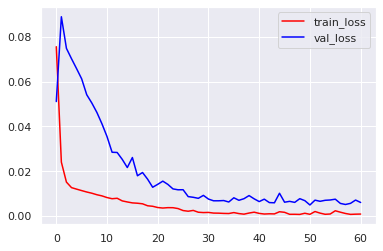

(5, 20, 7) (5, 1)
************************************************************
NMAE:  4.7762316467829
************************************************************


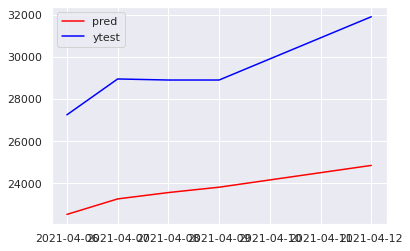

(5, 20, 7) (5, 1)
************************************************************
NMAE:  6.959148971325922
************************************************************


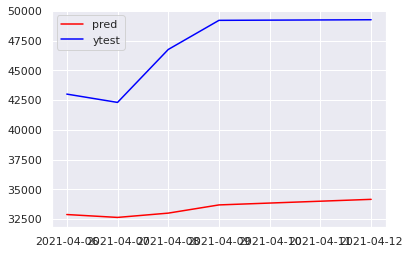

************************************************************
17 remain......
************************************************************
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 16)                1536      
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
12/12 [==============================] - 2s 52ms/step - loss: 0.1346 - val_loss: 0.5319
Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0574 - val_loss: 0.4237
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0383 - val_loss: 0.3813
Epoch

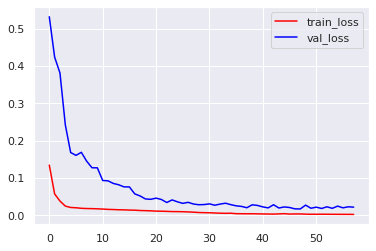

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.35319938887703006
************************************************************


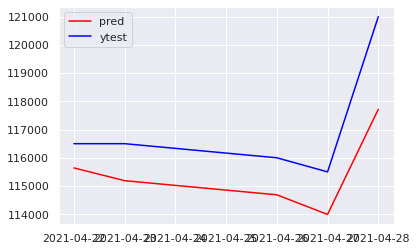

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.38476114298323294
************************************************************


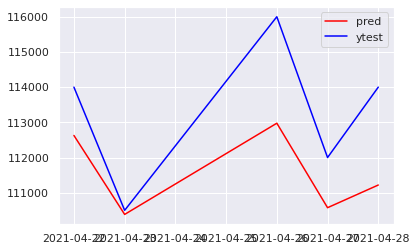

************************************************************
16 remain......
************************************************************
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 16)                1536      
                                                                 
 dense_52 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
14/14 [==============================] - 3s 50ms/step - loss: 0.0353 - val_loss: 0.1201
Epoch 2/100
14/14 [==============================] - 0s 10ms/step - loss: 0.0269 - val_loss: 0.1181
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 0.0251 - val_loss: 0.1105
Epoc

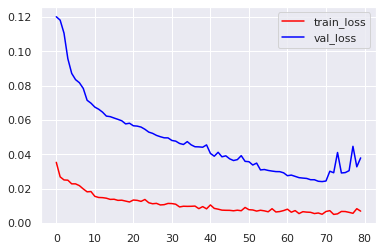

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.08601040845162987
************************************************************


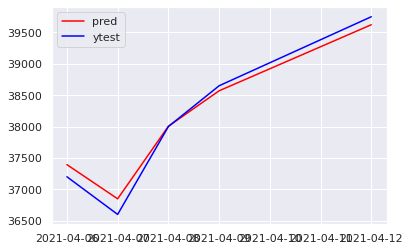

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.2912943151790957
************************************************************


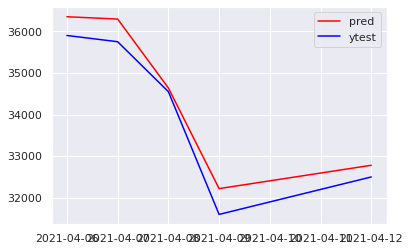

************************************************************
15 remain......
************************************************************
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 16)                1536      
                                                                 
 dense_53 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
13/13 [==============================] - 2s 51ms/step - loss: 0.0541 - val_loss: 0.0239
Epoch 2/100
13/13 [==============================] - 0s 13ms/step - loss: 0.0381 - val_loss: 0.0191
Epoch 3/100
13/13 [==============================] - 0s 13ms/step - loss: 0.0296 - val_loss: 0.0172
Epoc

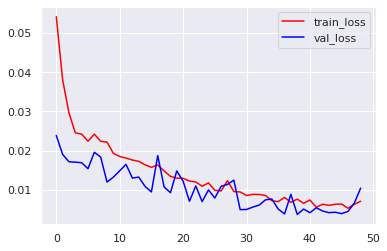

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.19987915130227782
************************************************************


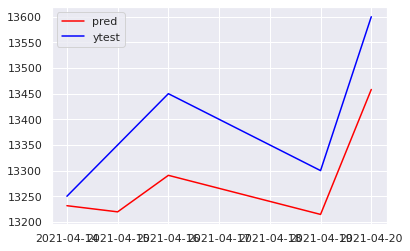

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.141518977128799
************************************************************


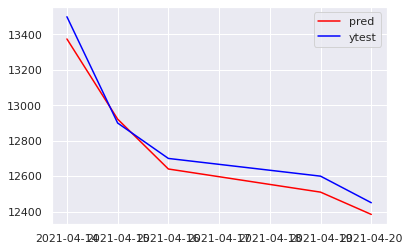

************************************************************
14 remain......
************************************************************
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 16)                1536      
                                                                 
 dense_54 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
12/12 [==============================] - 2s 52ms/step - loss: 0.0261 - val_loss: 0.6141
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0146 - val_loss: 0.5961
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0130 - val_loss: 0.5791
Epoch

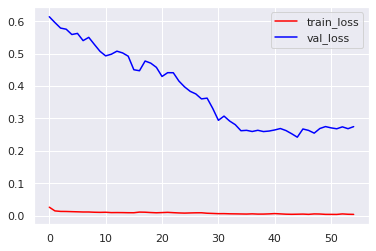

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.8034938430446243
************************************************************


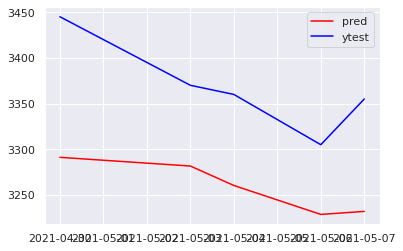

(5, 20, 7) (5, 1)
************************************************************
NMAE:  2.0777907036813326
************************************************************


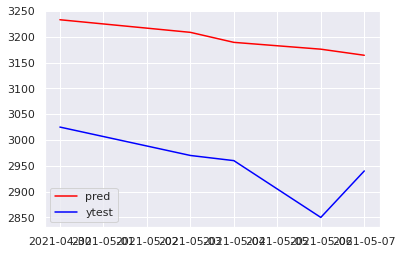

************************************************************
13 remain......
************************************************************
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 16)                1536      
                                                                 
 dense_55 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
12/12 [==============================] - 3s 85ms/step - loss: 0.6361 - val_loss: 0.9033
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 0.3429 - val_loss: 0.4901
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1016 - val_loss: 0.1292
Epoc

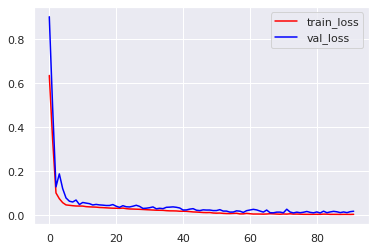

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.39115024377726454
************************************************************


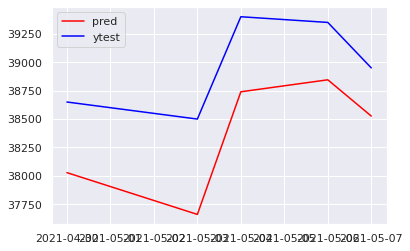

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.5104976132326821
************************************************************


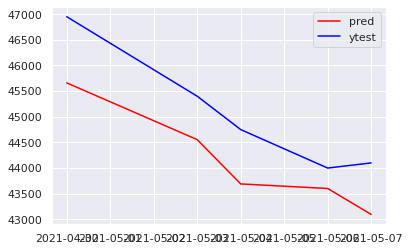

************************************************************
12 remain......
************************************************************
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 16)                1536      
                                                                 
 dense_56 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
9/9 [==============================] - 2s 72ms/step - loss: 0.4028 - val_loss: 0.2061
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 0.1030 - val_loss: 0.1243
Epoch 3/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0980 - val_loss: 0.0419
Epoch 4/10

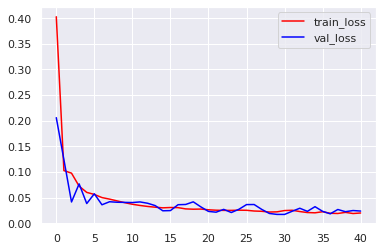

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.4278432892091153
************************************************************


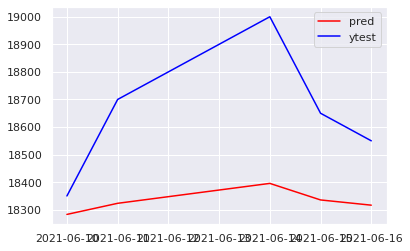

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.4529867772166486
************************************************************


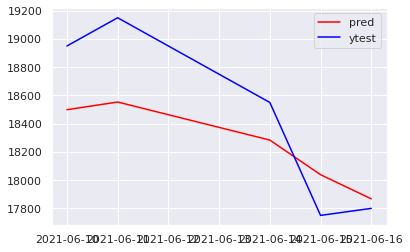

************************************************************
11 remain......
************************************************************
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 16)                1536      
                                                                 
 dense_57 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
5/5 [==============================] - 3s 201ms/step - loss: 0.3757 - val_loss: 0.2019
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 0.2444 - val_loss: 0.0825
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 0.1114 - val_loss: 0.0404
Epoch 4/1

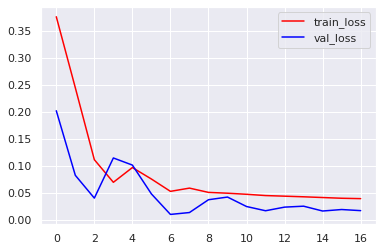

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.7005678705033254
************************************************************


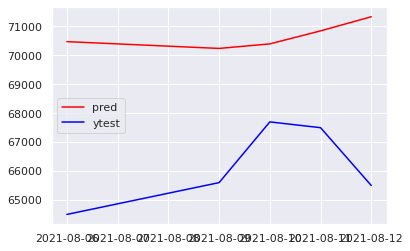

(5, 20, 7) (5, 1)
************************************************************
NMAE:  4.163092801979282
************************************************************


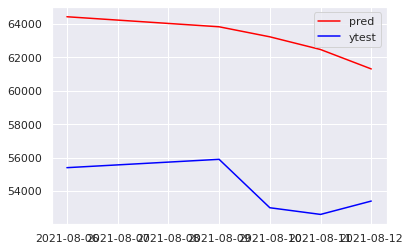

************************************************************
10 remain......
************************************************************
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 16)                1536      
                                                                 
 dense_58 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
6/6 [==============================] - 2s 111ms/step - loss: 0.2024 - val_loss: 0.0470
Epoch 2/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0951 - val_loss: 0.0825
Epoch 3/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0860 - val_loss: 0.0244
Epoch 4/1

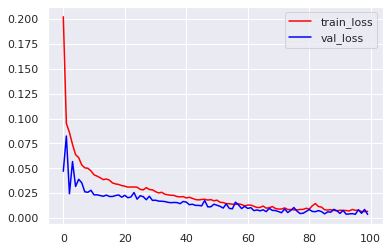

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.5303324272083161
************************************************************


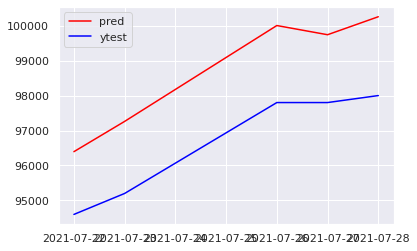

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.4531055699481865
************************************************************


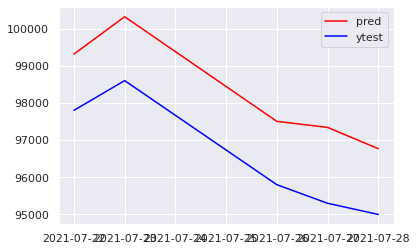

************************************************************
9 remain......
************************************************************
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 16)                1536      
                                                                 
 dense_59 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
9/9 [==============================] - 2s 71ms/step - loss: 0.2740 - val_loss: 0.1887
Epoch 2/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0912 - val_loss: 0.0648
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0815 - val_loss: 0.1034
Epoch 4/100


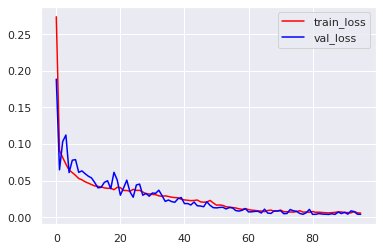

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.04469488973671434
************************************************************


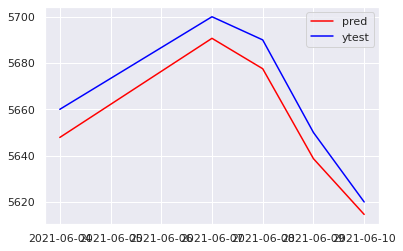

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.040757775477244275
************************************************************


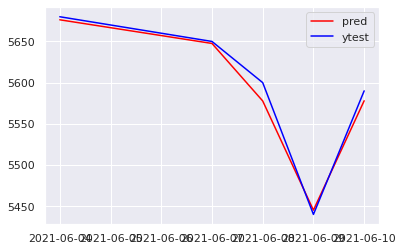

************************************************************
8 remain......
************************************************************
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 16)                1536      
                                                                 
 dense_60 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
4/4 [==============================] - 2s 185ms/step - loss: 0.2825 - val_loss: 0.2622
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1954 - val_loss: 0.1708
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.1320 - val_loss: 0.1028
Epoch 4/10

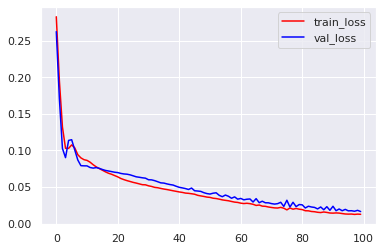

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.13559492021006697
************************************************************


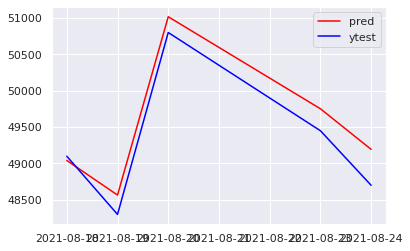

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.34421716405560376
************************************************************


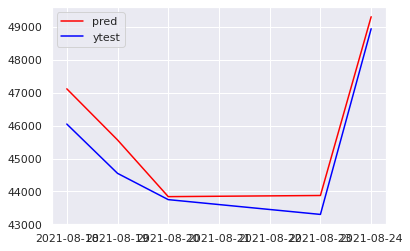

************************************************************
7 remain......
************************************************************
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 16)                1536      
                                                                 
 dense_61 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
10/10 [==============================] - 2s 66ms/step - loss: 0.2939 - val_loss: 0.2581
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1216 - val_loss: 0.0588
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0942 - val_loss: 0.0642
Epoch

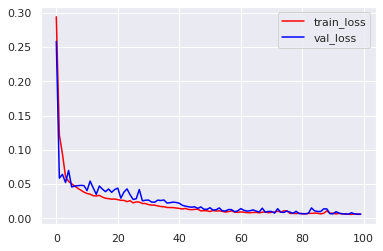

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.1868991794528904
************************************************************


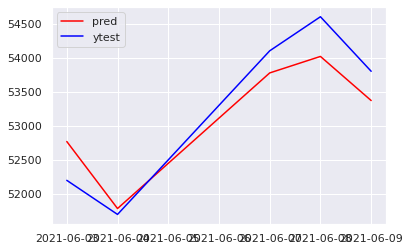

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.1445766715116279
************************************************************


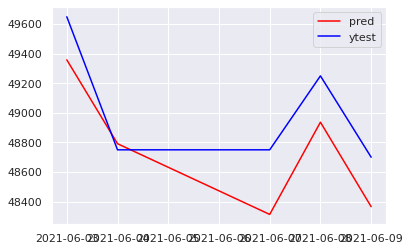

************************************************************
6 remain......
************************************************************
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 16)                1536      
                                                                 
 dense_62 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
10/10 [==============================] - 2s 65ms/step - loss: 0.4229 - val_loss: 0.3878
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1535 - val_loss: 0.0990
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0726 - val_loss: 0.0235
Epoch

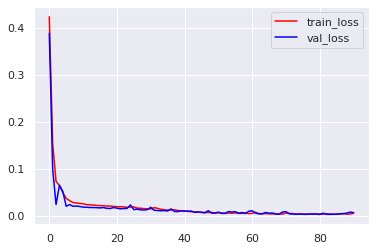

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.309620024932697
************************************************************


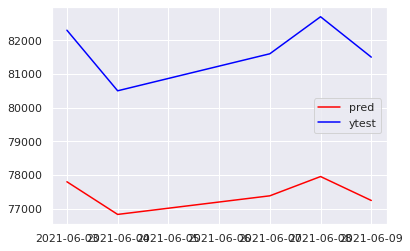

(5, 20, 7) (5, 1)
************************************************************
NMAE:  2.7165766240304294
************************************************************


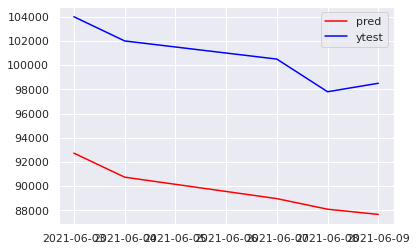

************************************************************
5 remain......
************************************************************
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 16)                1536      
                                                                 
 dense_63 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
4/4 [==============================] - 3s 277ms/step - loss: 0.2861 - val_loss: 0.3157
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 0.2034 - val_loss: 0.2113
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 0.1323 - val_loss: 0.1293
Epoch 4/10

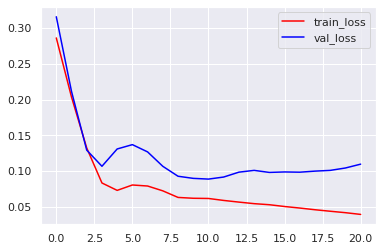

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.5555335994270543
************************************************************


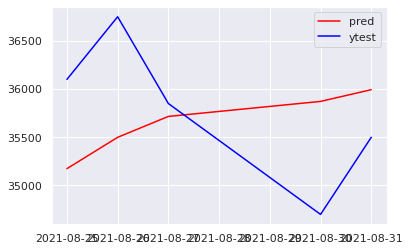

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.8041766022423026
************************************************************


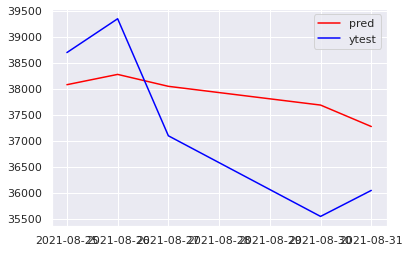

************************************************************
4 remain......
************************************************************
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 16)                1536      
                                                                 
 dense_64 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
4/4 [==============================] - 2s 183ms/step - loss: 0.1701 - val_loss: 0.1416
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0958 - val_loss: 0.0382
Epoch 3/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0956 - val_loss: 0.0294
Epoch 4/10

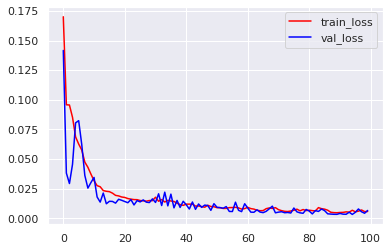

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.5462843525136138
************************************************************


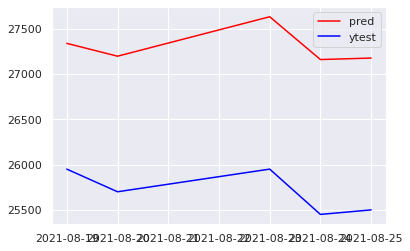

(5, 20, 7) (5, 1)
************************************************************
NMAE:  3.7875014909351146
************************************************************


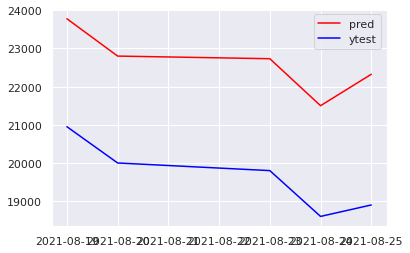

************************************************************
3 remain......
************************************************************
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 16)                1536      
                                                                 
 dense_65 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
5/5 [==============================] - 2s 128ms/step - loss: 0.2671 - val_loss: 0.0402
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 0.1034 - val_loss: 0.1527
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 0.1203 - val_loss: 0.0829
Epoch 4/10

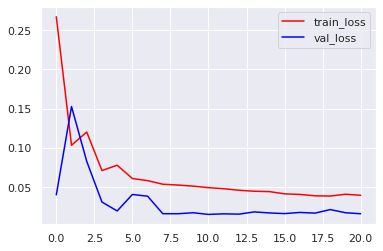

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.3671976490329099
************************************************************


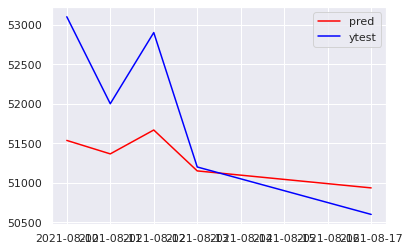

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.2501448393847576
************************************************************


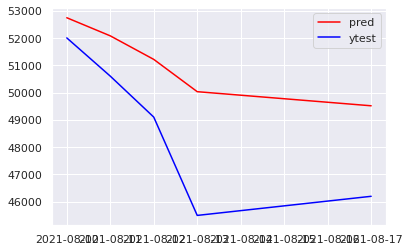

************************************************************
2 remain......
************************************************************
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 16)                1536      
                                                                 
 dense_66 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
5/5 [==============================] - 2s 134ms/step - loss: 0.4103 - val_loss: 0.6875
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 0.2846 - val_loss: 0.5012
Epoch 3/100
5/5 [==============================] - 0s 22ms/step - loss: 0.1747 - val_loss: 0.3247
Epoch 4/10

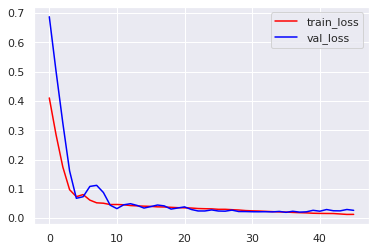

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.22756918420294034
************************************************************


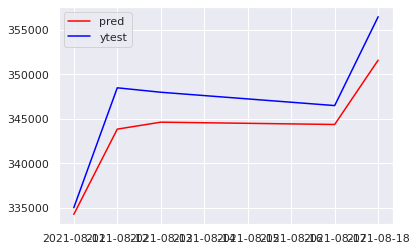

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.3579917615947925
************************************************************


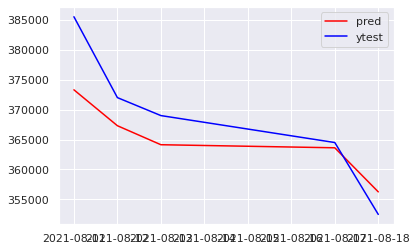

************************************************************
1 remain......
************************************************************
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 16)                1536      
                                                                 
 dense_67 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
6/6 [==============================] - 2s 101ms/step - loss: 0.5769 - val_loss: 0.7788
Epoch 2/100
6/6 [==============================] - 0s 16ms/step - loss: 0.3987 - val_loss: 0.5280
Epoch 3/100
6/6 [==============================] - 0s 13ms/step - loss: 0.2287 - val_loss: 0.2794
Epoch 4/10

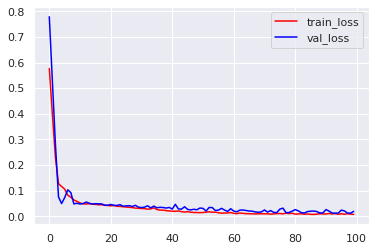

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.13225989222628476
************************************************************


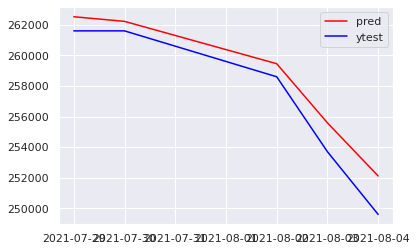

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.13376692234074183
************************************************************


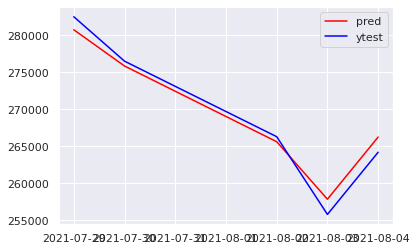

************************************************************
0 remain......
************************************************************
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 16)                1536      
                                                                 
 dense_68 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
5/5 [==============================] - 2s 133ms/step - loss: 0.3605 - val_loss: 0.5546
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 0.2200 - val_loss: 0.3490
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0917 - val_loss: 0.1440
Epoch 4/10

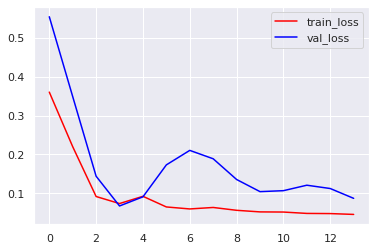

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.40304801231802845
************************************************************


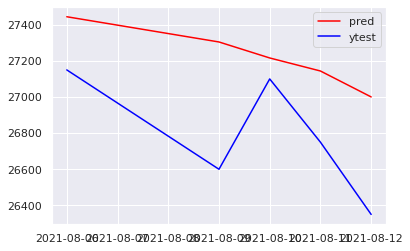

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.7114558076248453
************************************************************


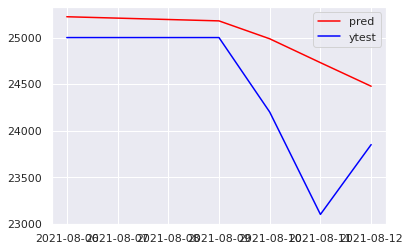

************************************************************
-1 remain......
************************************************************
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 16)                1536      
                                                                 
 dense_69 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/23 [==============================] - 3s 46ms/step - loss: 0.0093 - val_loss: 0.1136
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0052 - val_loss: 0.0882
Epoch 3/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0040 - val_loss: 0.0749
Epoc

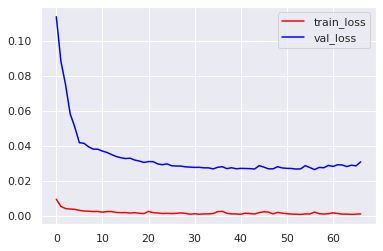

(5, 20, 7) (5, 1)
************************************************************
NMAE:  0.2939370505499154
************************************************************


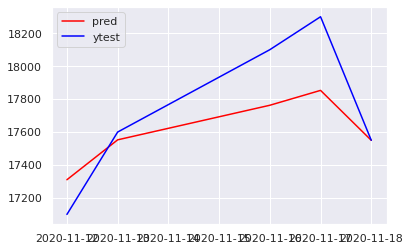

(5, 20, 7) (5, 1)
************************************************************
NMAE:  1.1314389133725071
************************************************************


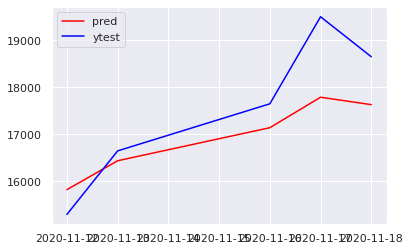

[]


In [ ]:
i=351
for stock_code in stock_list[351:]:
    i += 1
    print('**'*30)
    print(370-i,"remain......") # 370 == len(stock_list)-1
    print('**'*30)
   
    try:
        stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)
        # -----------------------------moving average ---------------------------
        stock_q = stock_q.fillna(method = 'bfill')
        stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
        stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
        # stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
        stock_q = stock_q.dropna()
        # -----------------------------------------------------------------------

        X, y = target_split(stock_q)

        mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
        mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

        X_scaled = mms_X.fit_transform(X)
        y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

        X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
        y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

        X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
        X_train, X_val, y_train, y_val = val_split(X_train, y_train)


        mt = my_train(X_train, y_train)

        mt.window_data()

        mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

        pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
        pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

        pred = np.zeros((10,1))
        pred[:5] = pred1
        pred[5:] = pred2

        sub[stock_code] = pred
    except:
        error_list.append(stock_code)

sub.to_csv(f'{SUBPATH__}/sub8.csv')
print(error_list)

In [ ]:
i=1
for stock_code in stock_list[1:43]:
    i += 1
    print('**'*30)
    print(370-i,"remain......") # 370 == len(stock_list)-1
    print('**'*30)
   
    try:
        stock_q = fdr.DataReader(stock_code, start = start_date, end = end_date)
        # -----------------------------moving average ---------------------------
        stock_q = stock_q.fillna(method = 'bfill')
        stock_q['ma5'] = stock_q['Open'].rolling(5).mean()
        stock_q['ma20'] = stock_q['Open'].rolling(20).mean()
        # stock_q['ma50'] = stock_q['Open'].rolling(50).mean()
        stock_q = stock_q.dropna()
        # -----------------------------------------------------------------------

        X, y = target_split(stock_q)

        mms_X = MinMaxScaler() # ex. mms_X = MinMaxScaler()
        mms_y = MinMaxScaler() # ex. mms_X = MinMaxScaler()

        X_scaled = mms_X.fit_transform(X)
        y_scaled = mms_y.fit_transform(y.values.reshape(-1,1))

        X = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
        y = pd.DataFrame(y_scaled, columns = [y.name], index = y.index)

        X_train, y_train, X_test1, y_test1, X_test2, y_test2 = test_split(X, y)
        X_train, X_val, y_train, y_val = val_split(X_train, y_train)


        mt = my_train(X_train, y_train)

        mt.window_data()

        mt.my_fit(hidden_layer=None, return_sequences = False, units__=UNITS__, epochs__=EPOCHS__, model_path = MODELPAHT__)

        pred1 = mt.my_predict(X_test1, y_test1, mms_y, True, window_size=WINDOW_SIZE__)
        pred2 = mt.my_predict(X_test2, y_test2, mms_y, True, window_size=WINDOW_SIZE__)

        pred = np.zeros((10,1))
        pred[:5] = pred1
        pred[5:] = pred2

        sub[stock_code] = pred
    except:
        error_list.append(stock_code)

sub.to_csv(f'{SUBPATH__}/sub9.csv')
print(error_list)

In [ ]:
asdfasfasfd

NameError: ignored

In [ ]:
print(error_list)

# 추가 개선사항
: VIX나 다른 일별 지표 활용해본다면?  
: Close 그냥 밀어버렸는데 안 밀고 전날 종가 피쳐 남겨두고 이걸 MA에 활용했어도 좋았을듯.  
: validation을 이번에는 임의로 0.2로 설정했는데, 다른 코드 참고해보니 val 날짜를 목표 날짜의 최근 1,2주 이정도로 짧게 뒀다. 최근 데이터를 잘 맞추는 가중치에 더 중점을 두기 위함 -> val을 더 짧게 잡아보자.  
: Depth를 더 깊게  
: window size 20인데 한 달 치 데이터로 보는 거라 너무 긴듯... 좀 줄이자

# 전체 데이터에 대해 모델 돌리기
<방법>
1. 모든 개별 회사에 대해 fit
2. 산업별 대표격 되는 회사에 대해 fit 하고 weight 사용해서 나머지 빨리 돌림(근데 금방 돌아가는데 모델이 안 딥해서)ㅡ

In [ ]:
############################################################

In [ ]:
start_date='2000-01-01'
end_date='2021-12-15'

# plt.plot(vix[(start_date <= vix.index) & (vix.index <= end_date)]['Close'], label='Close')
plt.plot(vix[(start_date <= vix.index) & (vix.index <= end_date)]['Change']*100, label='Change*100')
# plt.plot(stock_p[(start_date <= stock_p.index) & (stock_p.index <= end_date)]['Close'], label='Close_p')
plt.plot(stock_p[(start_date <= stock_p.index) & (stock_p.index <= end_date)]['Change']*100, label='p_Change*100')
# plt.plot(stock_q[(start_date <= stock_q.index) & (stock_q.index <= end_date)]['Close'], label='Close_q')
plt.plot(stock_q[(start_date <= stock_q.index) & (stock_q.index <= end_date)]['Change']*100, label='q_Change*100')


plt.legend()
plt.show()

In [ ]:
temp1 = vix[(start_date <= vix.index) & (vix.index <= end_date)][['Change', 'Close']]
temp2 = stock_p[(start_date <= stock_p.index) & (stock_p.index <= end_date)][['Change', 'Close']]
temp3 = stock_q[(start_date <= stock_q.index) & (stock_q.index <= end_date)][['Change', 'Close']]

temp = pd.concat([temp1, temp2, temp3], axis=1)

In [ ]:
temp.columns=['Change_vix', 'Close_vix', 'Change_p', 'Close_p', 'Change_q', 'Close_q']

In [ ]:
temp_list = [col for col in temp.columns if 'Close' in col]
sns.heatmap(temp[temp_list].corr(), annot=True, fmt=".2f", center=0, cmap='YlGnBu')

In [ ]:
temp_list = [col for col in temp.columns if 'Change' in col]
sns.heatmap(temp[temp_list].corr(), annot=True, fmt=".2f", center=0, cmap='YlGnBu')

In [ ]:
sns.heatmap(abs(temp.corr()), annot=True, fmt=".2f", center=0, cmap='YlGnBu')